<a href="https://colab.research.google.com/github/Ilvecho/Project_5/blob/main/Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from datetime import timedelta

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

!pip install pmdarima
import pmdarima as pm
from pmdarima import auto_arima

import pickle
from google.colab import drive
drive.mount('/content/gdrive')

# Import and parse data

In [2]:
files.upload()
pass

Saving 2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv to 2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv to 2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv to 2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv to 2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv to 2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv to 2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv to 2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv
Saving 2020Q1Q2Q

In [3]:
def parse_vol(raw_x):

  x = raw_x.replace('.', '')
  if x[-1] == 'K':
    x = x.replace('K', '0')
  elif x[-1] == 'M':
    x = x.replace('M', '0000')
  try:
    return float(x)
  except:
    return np.nan

In [4]:
file_list = os.listdir('/content/')
data = {}

for filename in file_list:
  if filename.startswith('2020Q1'):

    # Extract the country from the file name
    country = filename.split(' - ')[1].strip()
    tmp_data = pd.read_csv(filename)[:-1]

    # Set the Date as proper dtype, and set it as index
    tmp_data['Date'] = pd.to_datetime(tmp_data['Date'])
    tmp_data.set_index('Date', inplace=True)

    # Parse the columns
    # Price
    tmp_data['Price'] = tmp_data['Price'].apply(lambda x: x.replace(',', ''))
    tmp_data['Price'] = pd.to_numeric(tmp_data['Price'])

    # Open
    tmp_data['Open'] = tmp_data['Open'].apply(lambda x: x.replace(',', ''))
    tmp_data['Open'] = pd.to_numeric(tmp_data['Open'])


    # High
    tmp_data['High'] = tmp_data['High'].apply(lambda x: x.replace(',', ''))
    tmp_data['High'] = pd.to_numeric(tmp_data['High'])

    # Low
    tmp_data['Low'] = tmp_data['Low'].apply(lambda x: x.replace(',', ''))
    tmp_data['Low'] = pd.to_numeric(tmp_data['Low'])

    # Vol.
    tmp_data['Vol.'] = tmp_data['Vol.'].apply(parse_vol)

    # Change %
    tmp_data['Change %'] = tmp_data['Change %'].apply(lambda x: float(x.strip('%')))

    # Set the frequency of the DataFrame to b = Business days
    tmp_data = tmp_data.asfreq('b')

    # By setting the frequency we create new rows which are empty (business days in which the stock market was closed, e.g. Public Holidays)
    # We need to fill the missing values, and we opt for a forward fill, i.e. we use the value of the previous day
    tmp_data = tmp_data.fillna(method='ffill')

    # sort the index
    tmp_data = tmp_data.sort_index()

    # Stored the processed data in the Dict
    data[country] = tmp_data

In [6]:
for key in data.keys():
  print('\n\n###########\n')
  print(key)
  print(data[key].info())



###########

South Africa
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 2020-01-02 to 2021-03-31
Freq: B
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     325 non-null    float64
 1   Open      325 non-null    float64
 2   High      325 non-null    float64
 3   Low       325 non-null    float64
 4   Vol.      325 non-null    float64
 5   Change %  325 non-null    float64
dtypes: float64(6)
memory usage: 17.8 KB
None


###########

Russia
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 324 entries, 2020-01-03 to 2021-03-31
Freq: B
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     324 non-null    float64
 1   Open      324 non-null    float64
 2   High      324 non-null    float64
 3   Low       324 non-null    float64
 4   Vol.      324 non-null    float64
 5   Change %  324 non-null    float64
dtypes: float64(6)

# Visual inspection

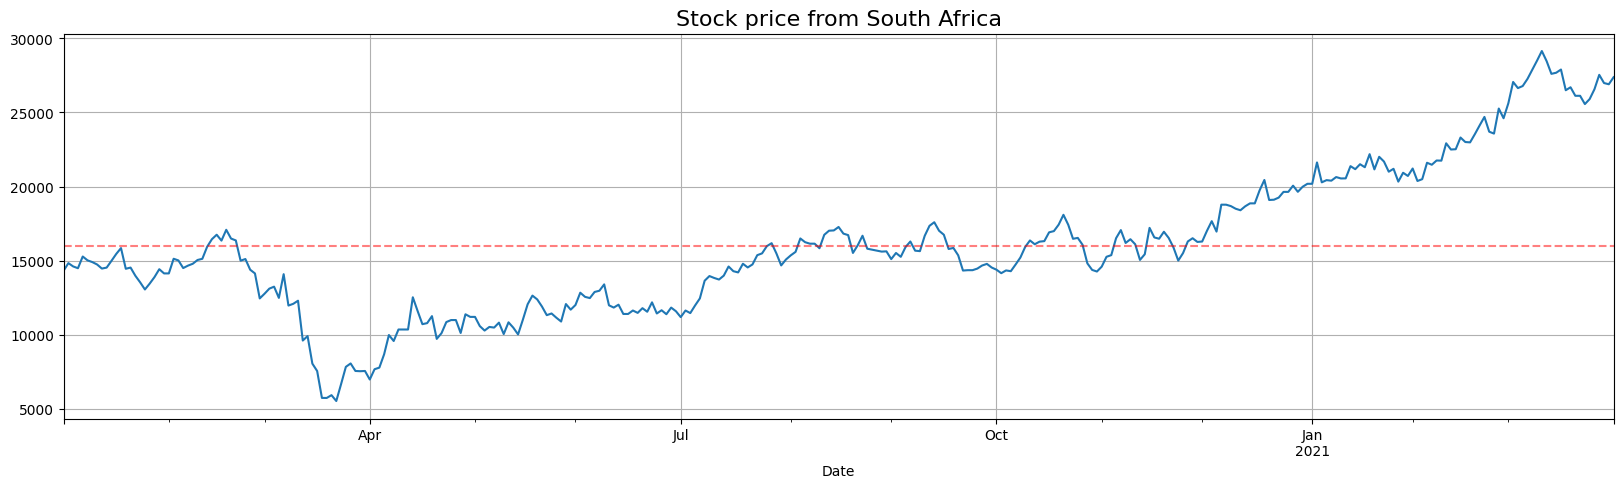

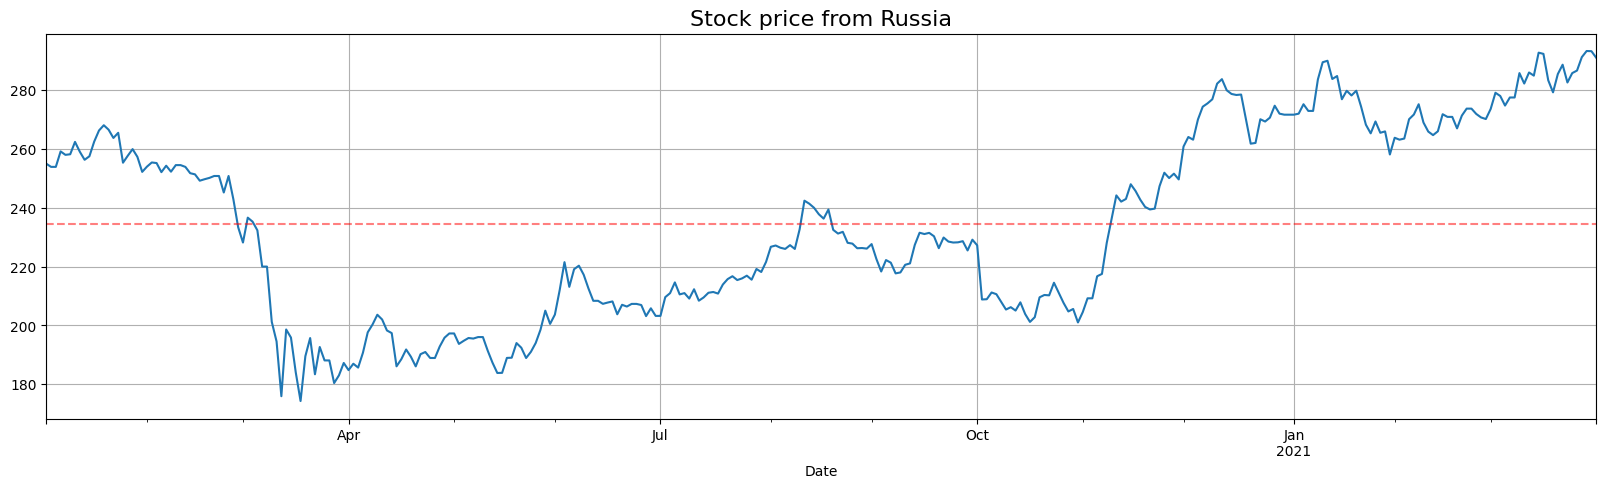

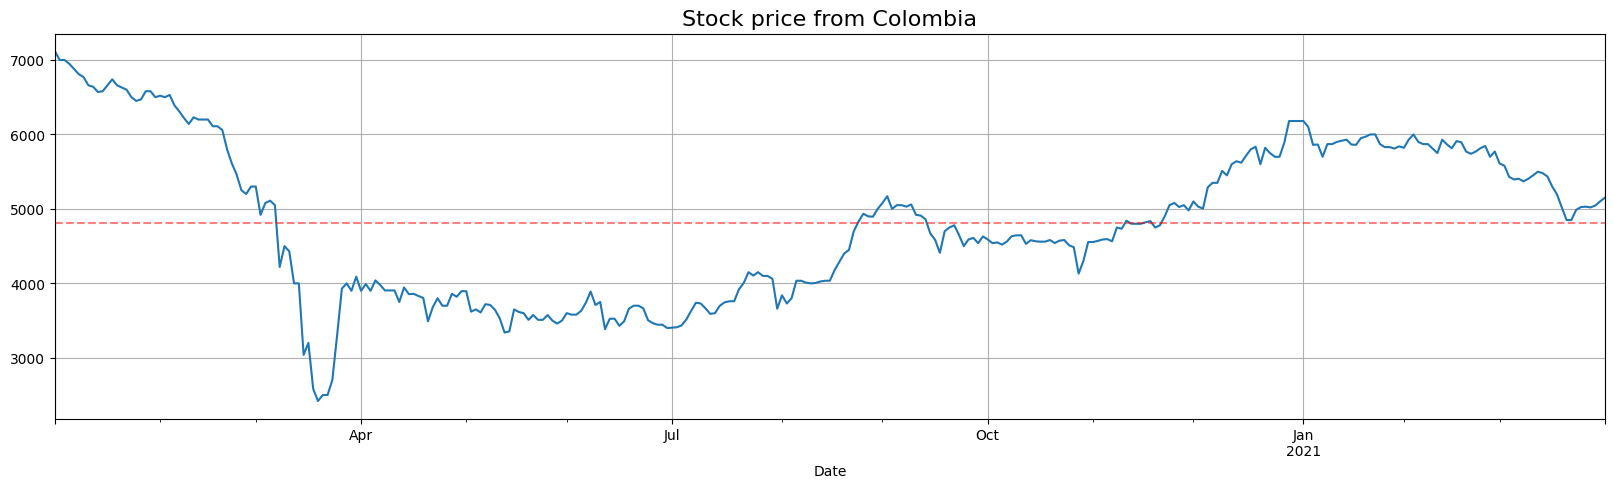

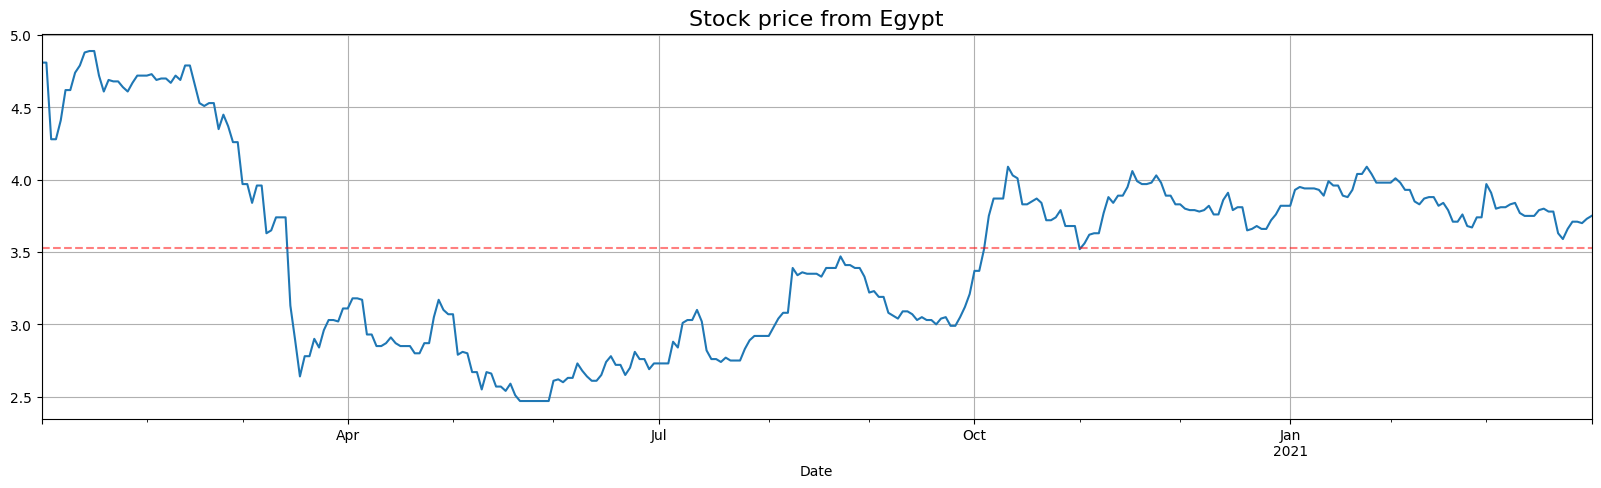

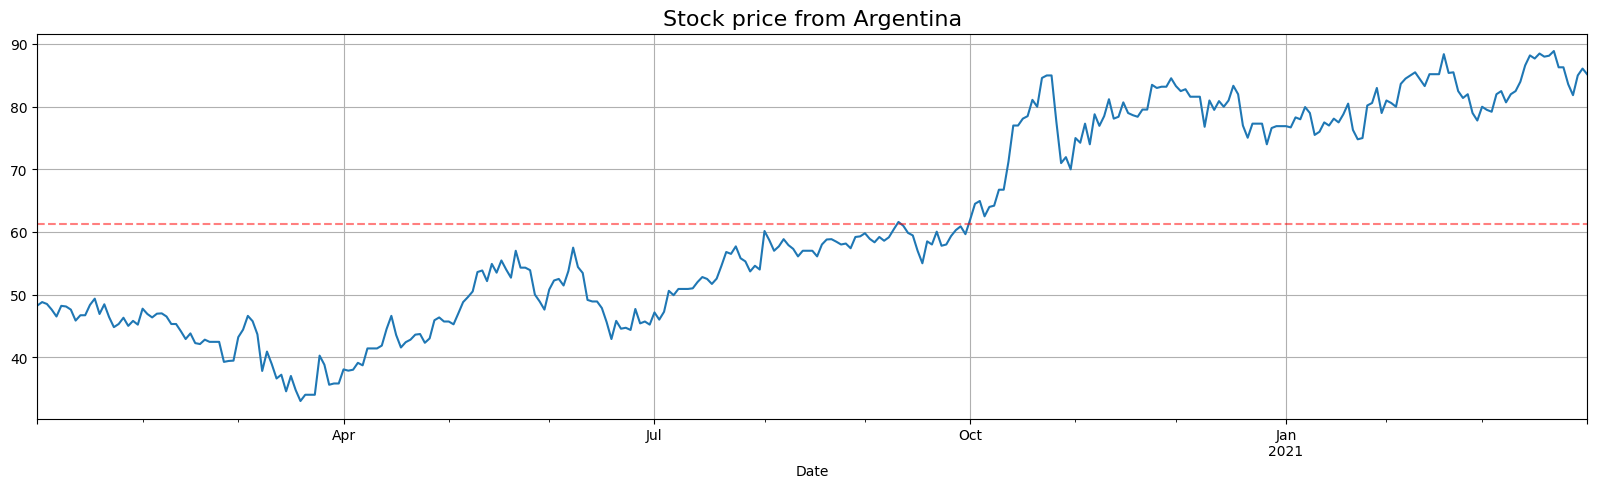

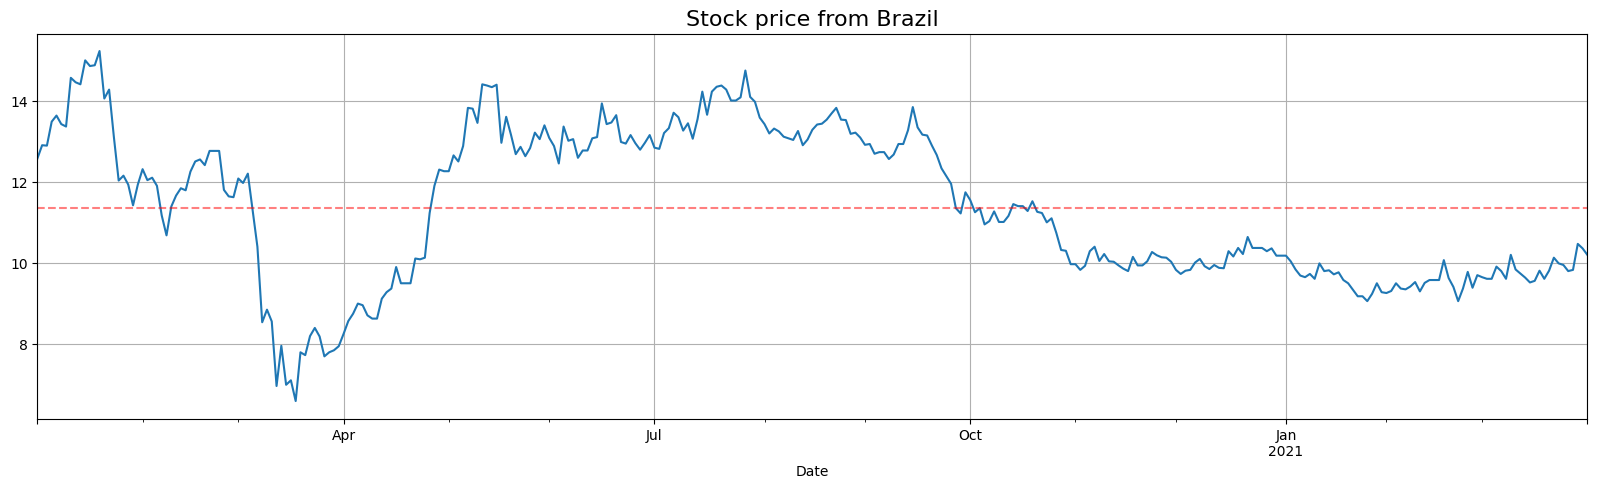

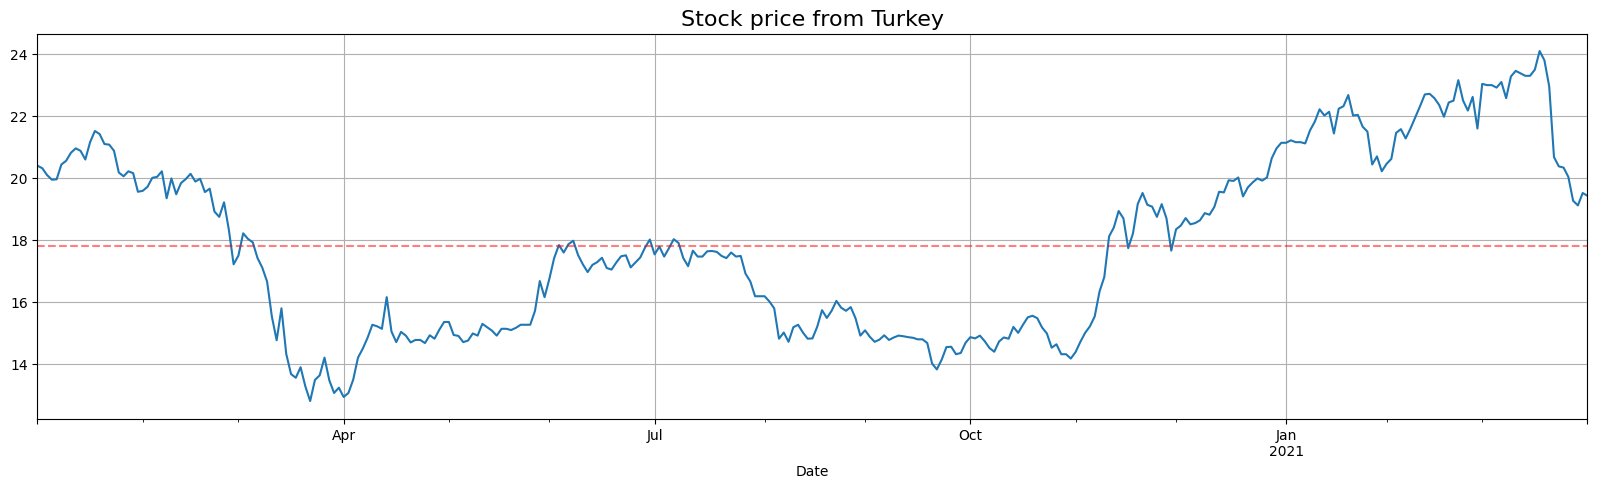

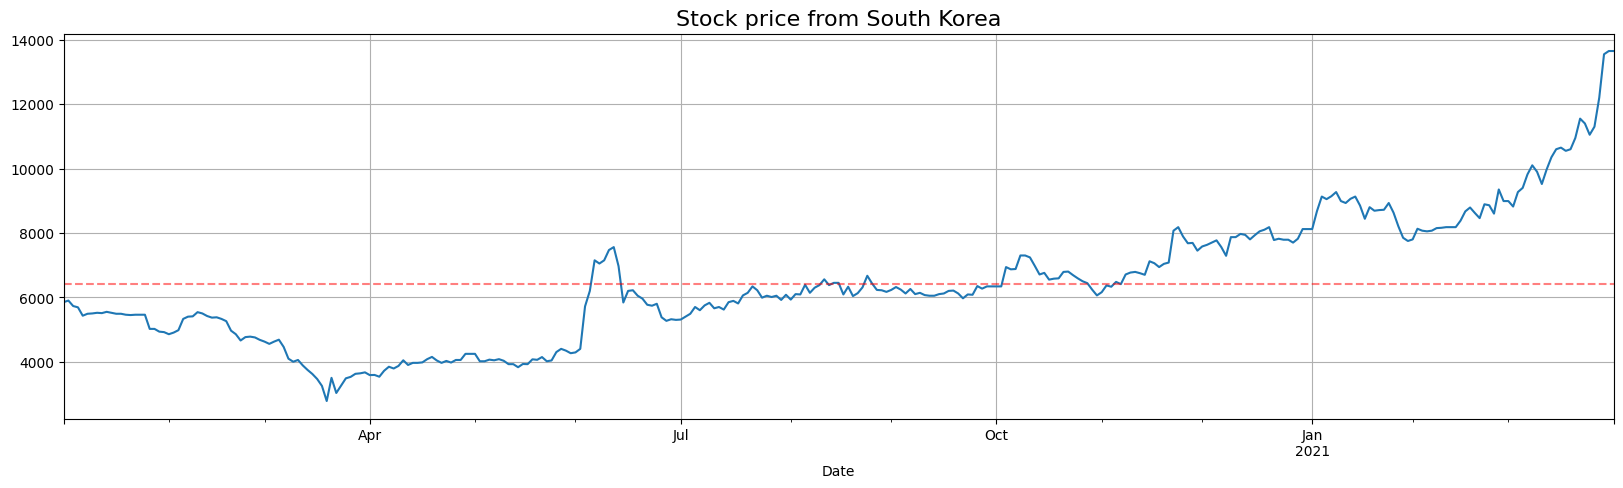

In [7]:
for key in data.keys():

  data[key]['Price'].plot(figsize=(20,5), grid='on')
  plt.axhline(y=data[key]['Price'].mean(), color='red',  alpha=0.5, linestyle='--')
  plt.title(f'Stock price from {key}', fontsize=16)

  plt.show()

We can clearly see that the Price time series are **not stationary** (we will robustly test this statement, but also the visual inspection is enough).

Most likely there is a trend factor in the time series. The integration component of the ARIMA model should take care of it

# EDA - stationarity

We verify the stationarity of the time series using the **Augmented Dickey-Fuller** test

In [8]:
for key in data.keys():
  p_price = adfuller(data[key]['Price'])

  print(f'##########\n{key.upper()}')
  print('The p-value of the price is: ', p_price[1])
  print('\n')

##########
SOUTH AFRICA
The p-value of the price is:  0.968855539556175


##########
RUSSIA
The p-value of the price is:  0.7374602050812519


##########
COLOMBIA
The p-value of the price is:  0.1879471059211641


##########
EGYPT
The p-value of the price is:  0.24529851951451465


##########
ARGENTINA
The p-value of the price is:  0.8756756136964812


##########
BRAZIL
The p-value of the price is:  0.18411806668707226


##########
TURKEY
The p-value of the price is:  0.5749764210297075


##########
SOUTH KOREA
The p-value of the price is:  0.9973977003970093




The Price is typically **non stationary**.

The exceptions are Egypt, Colombia and Brazil, which show a stationary stock price as well

# EDA - autocorrelation

let's compute the autocorrelation of the Price time series

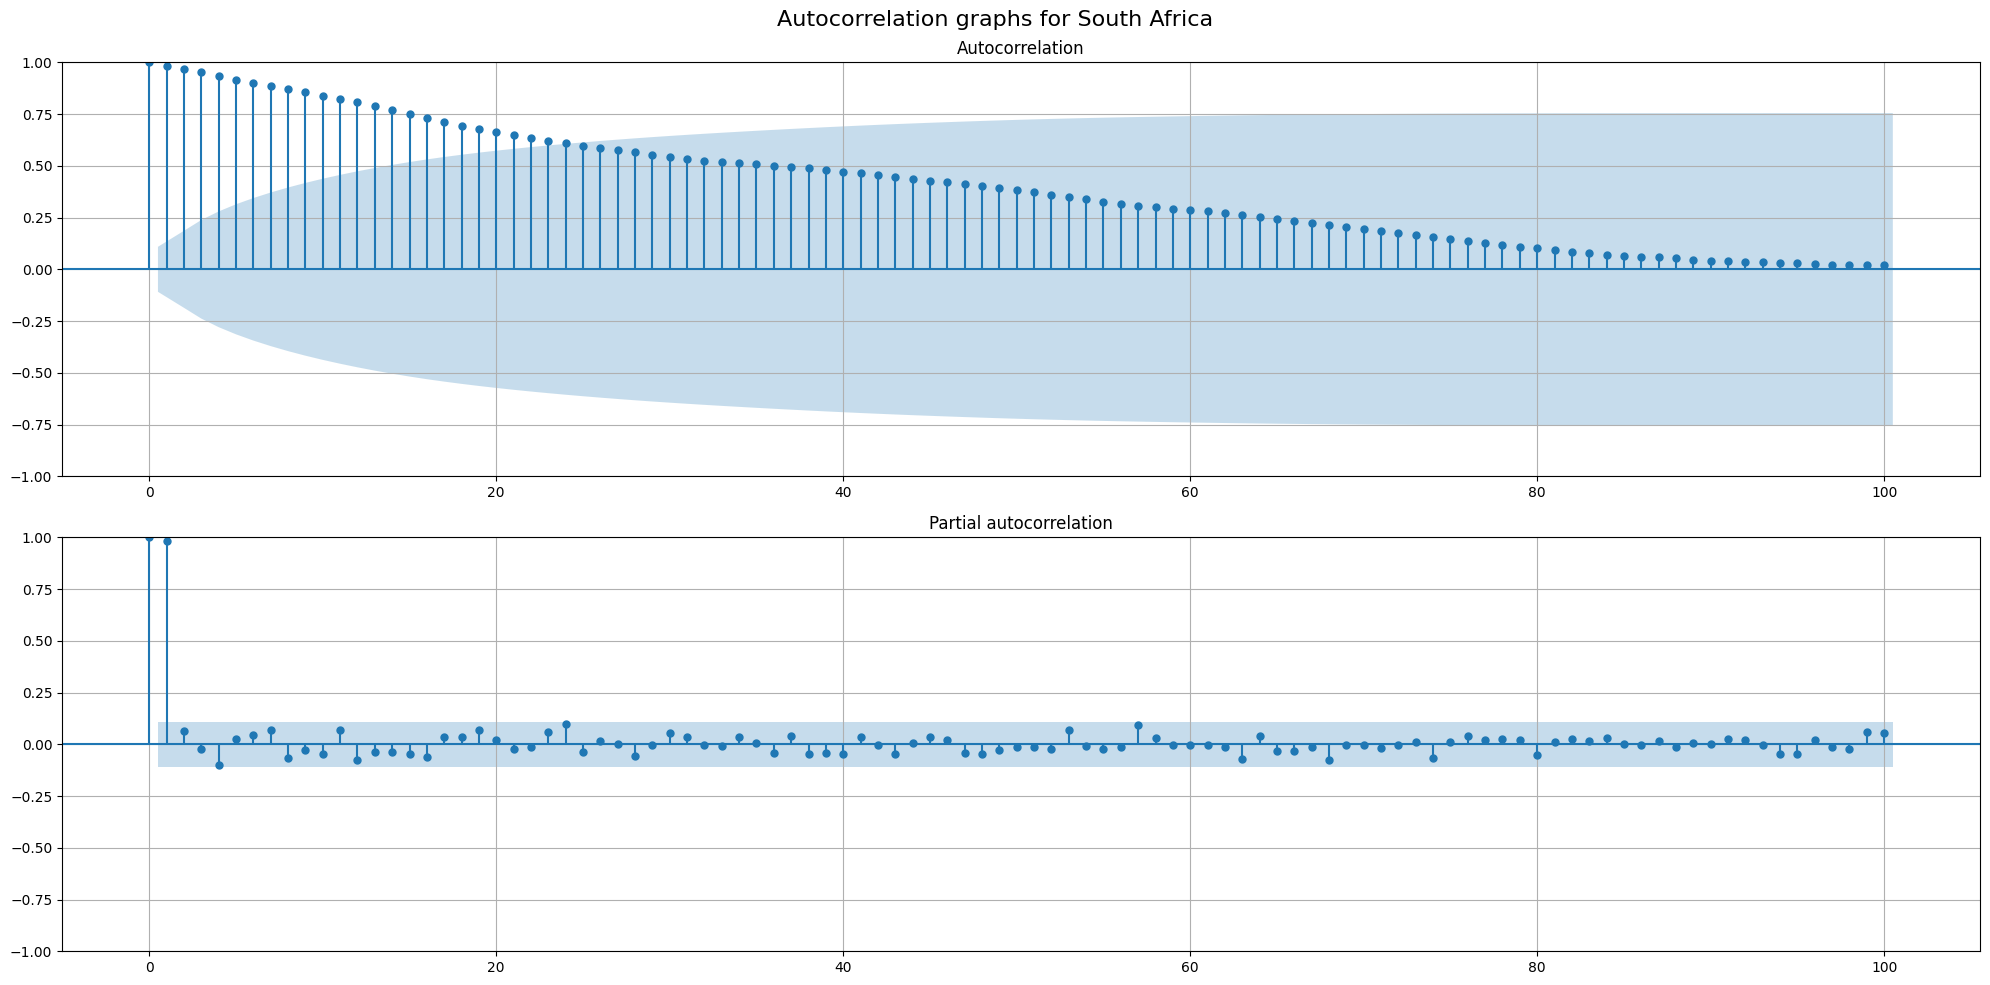

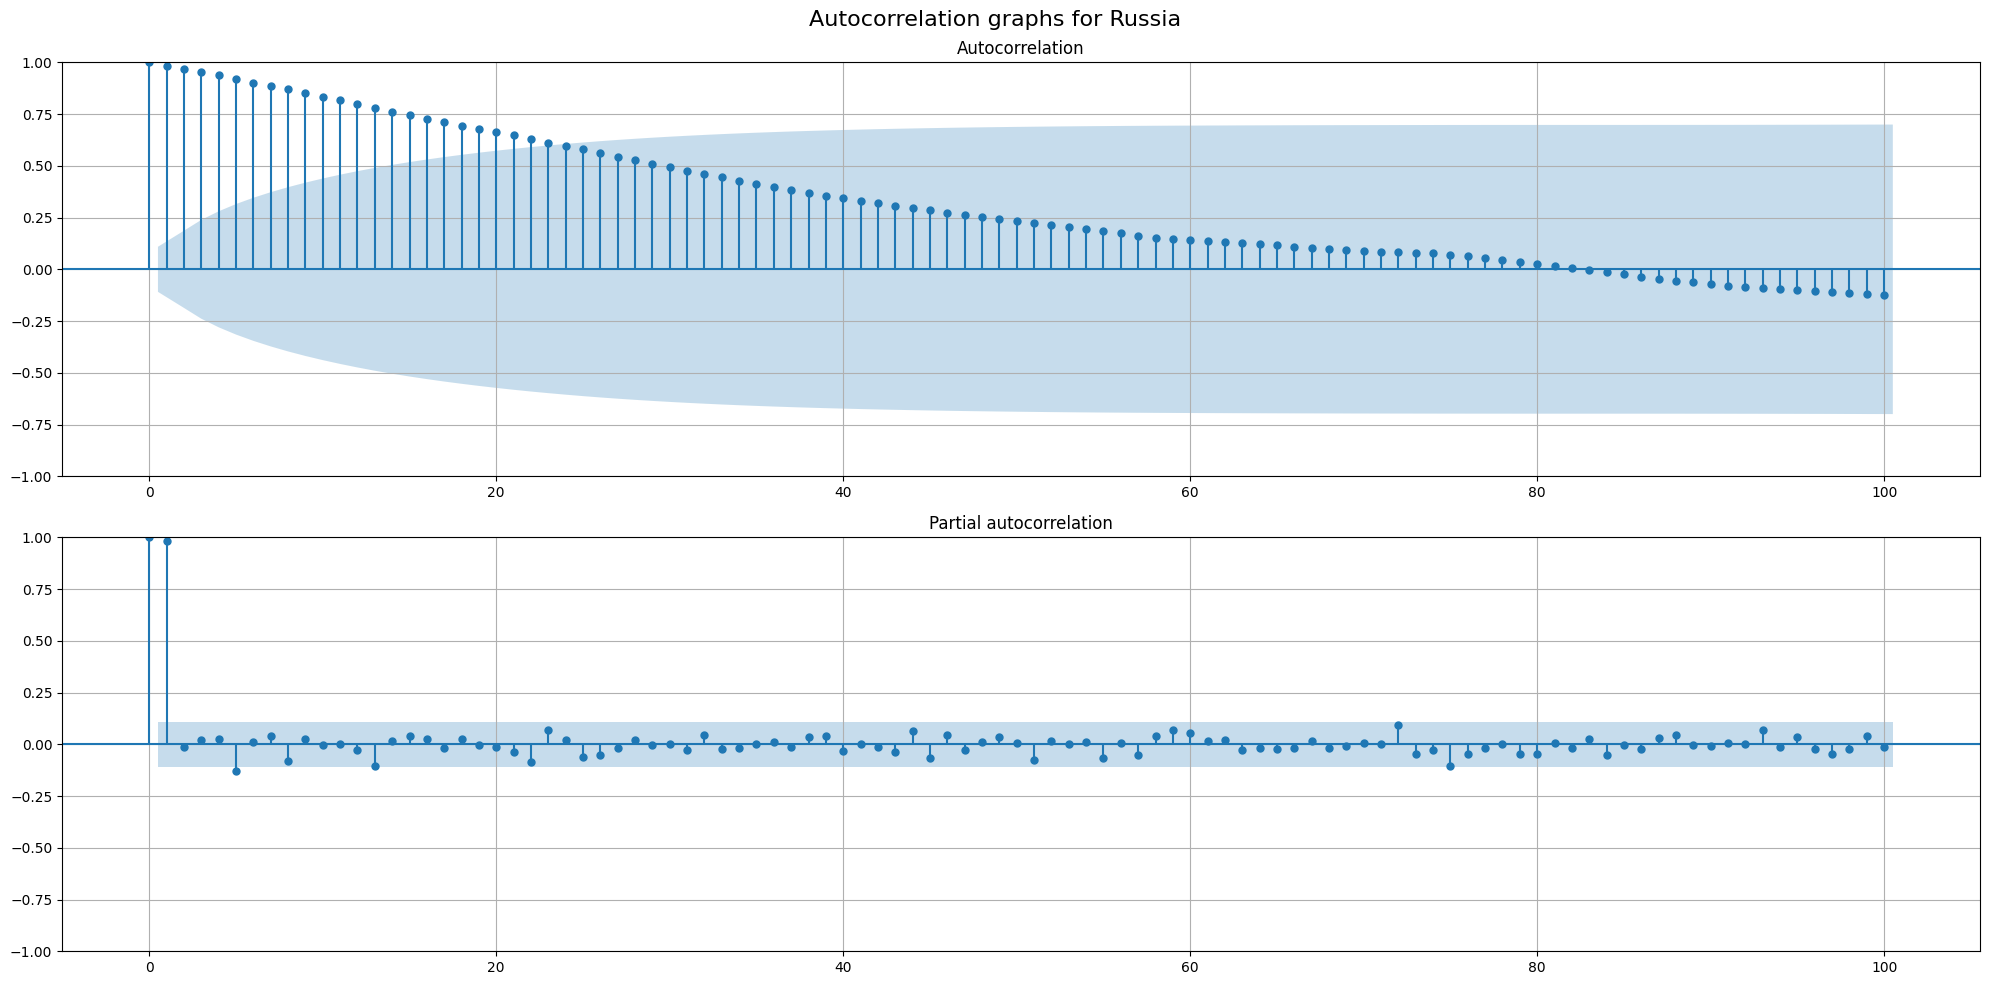

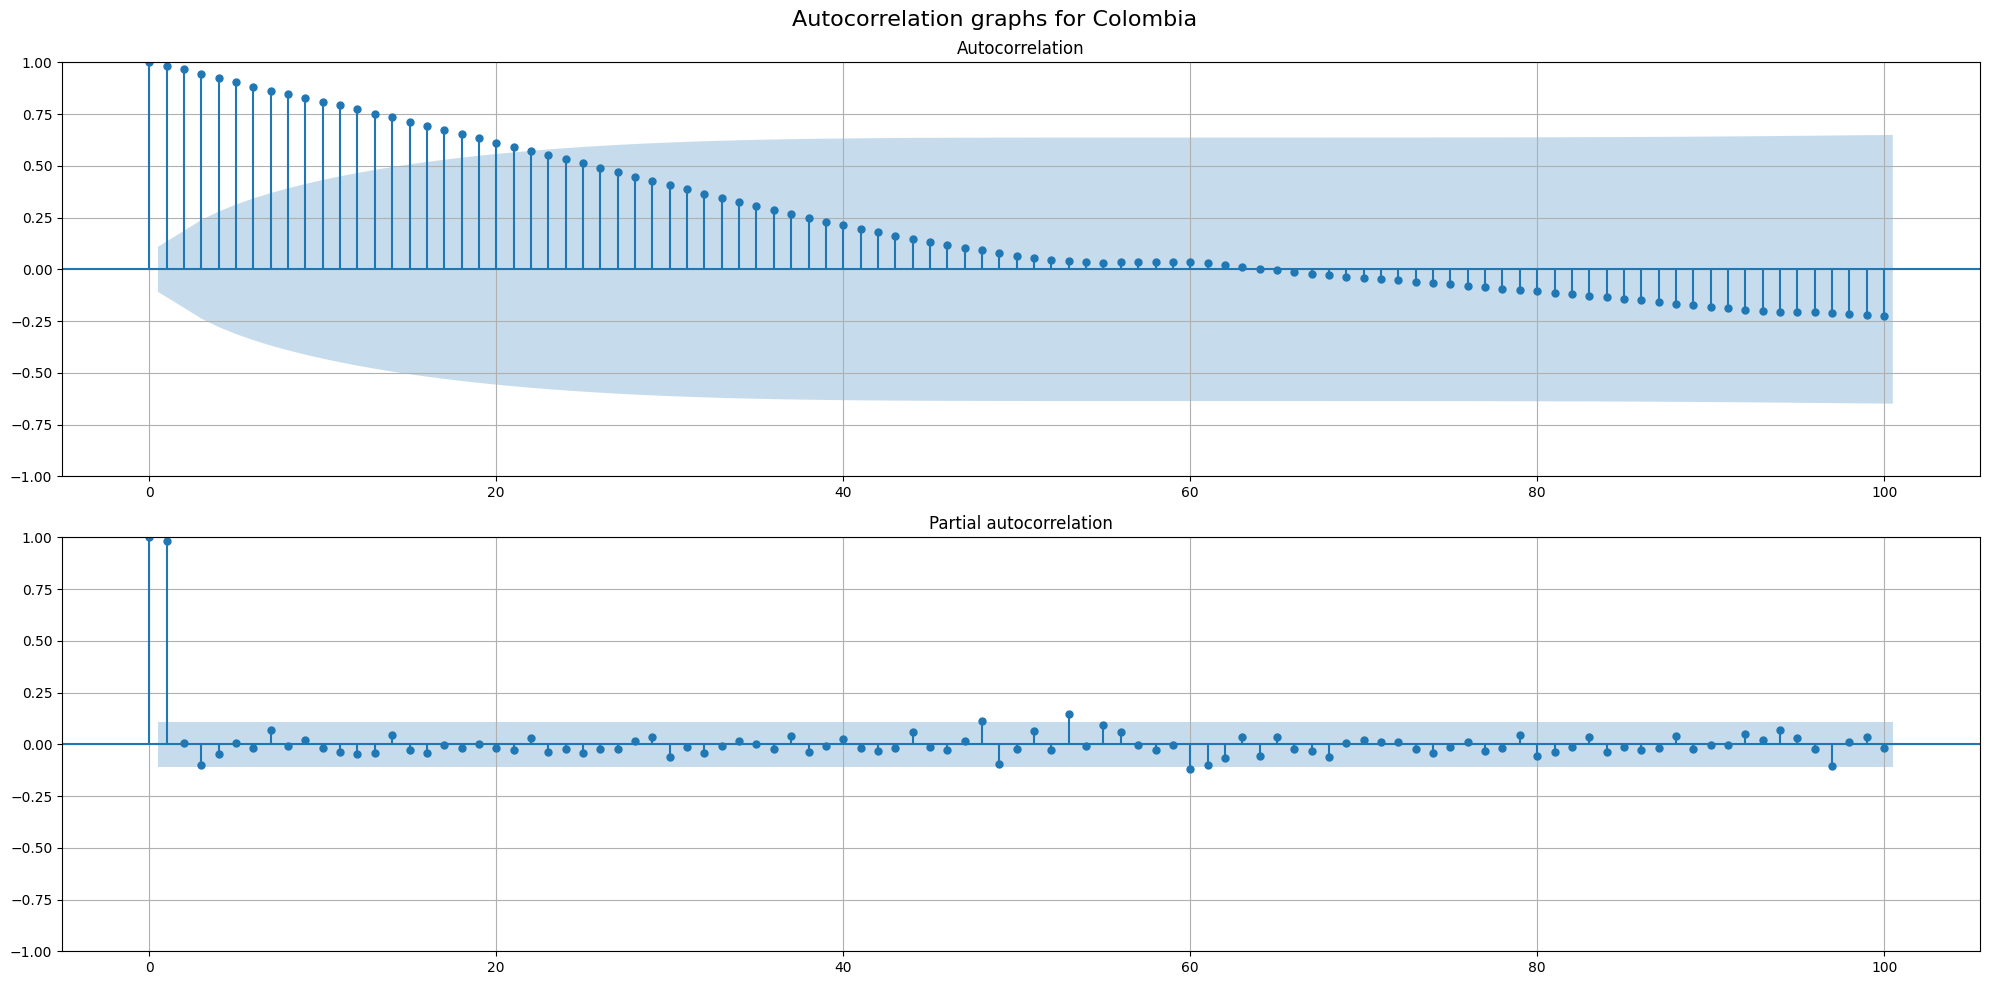

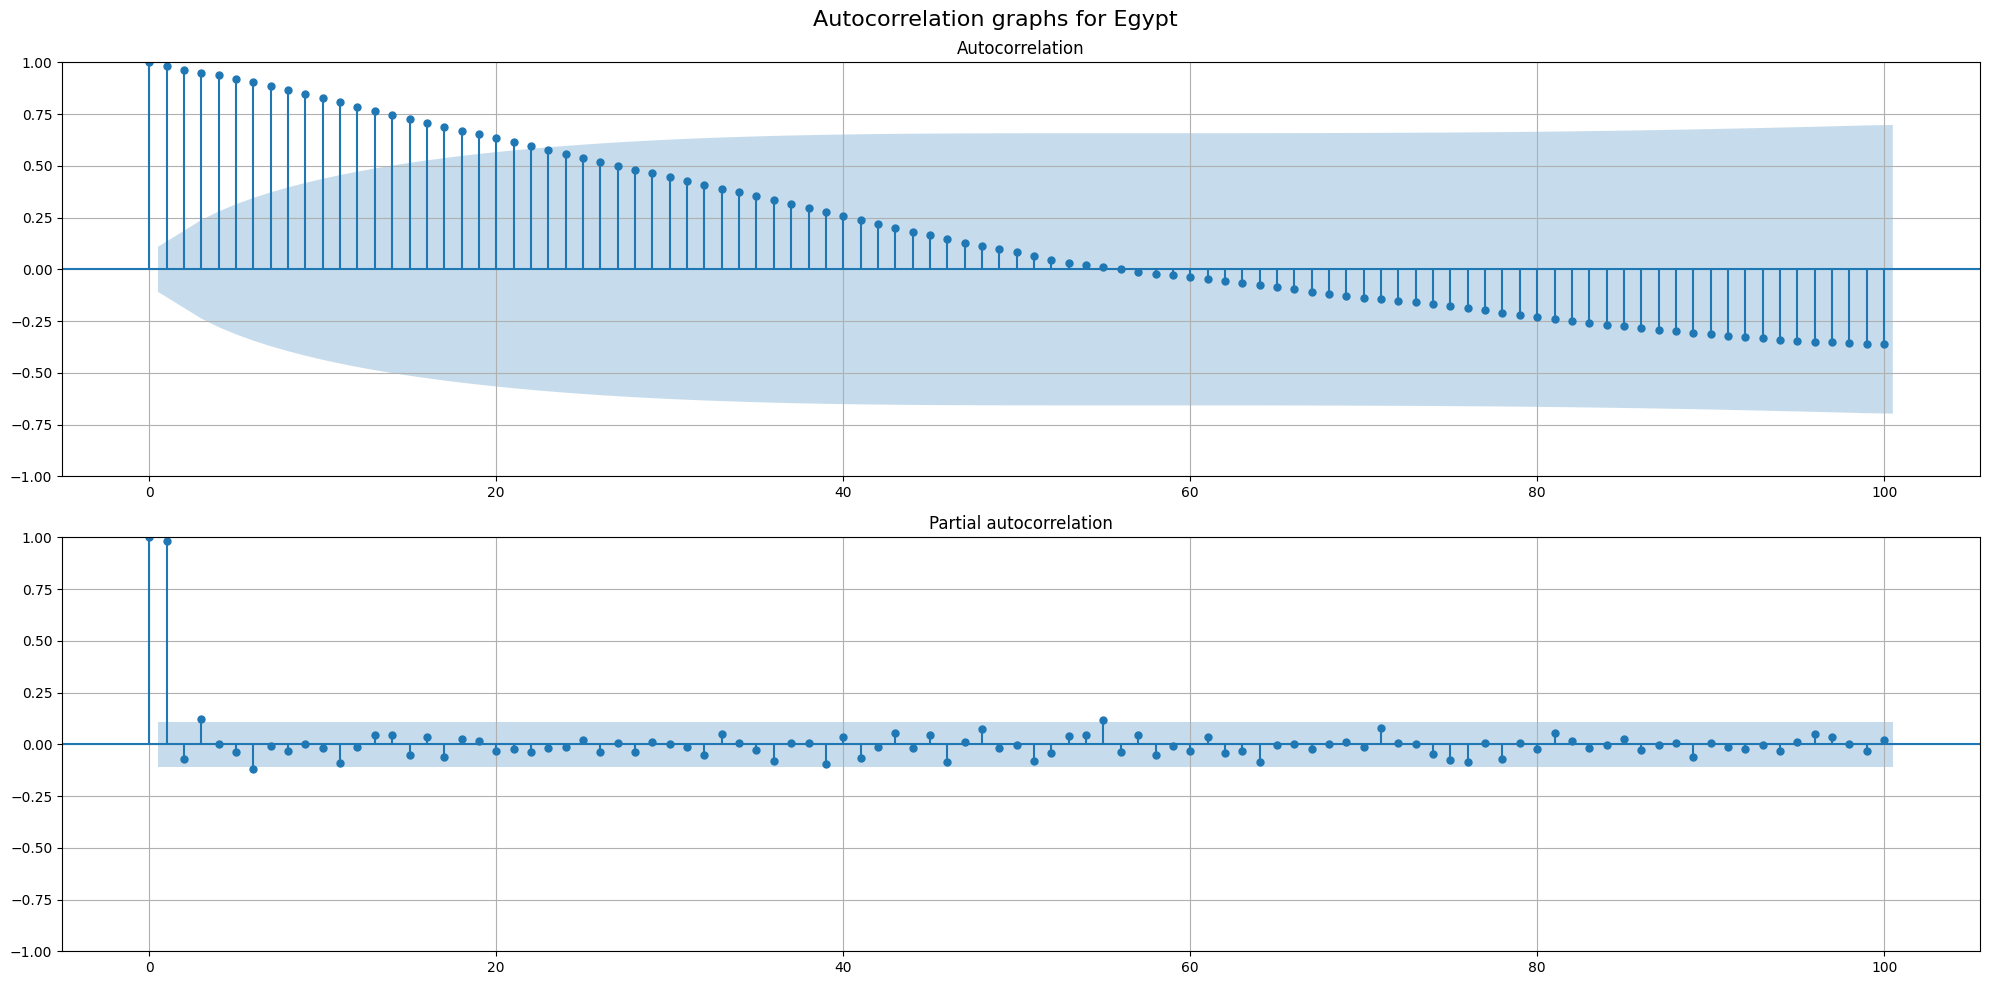

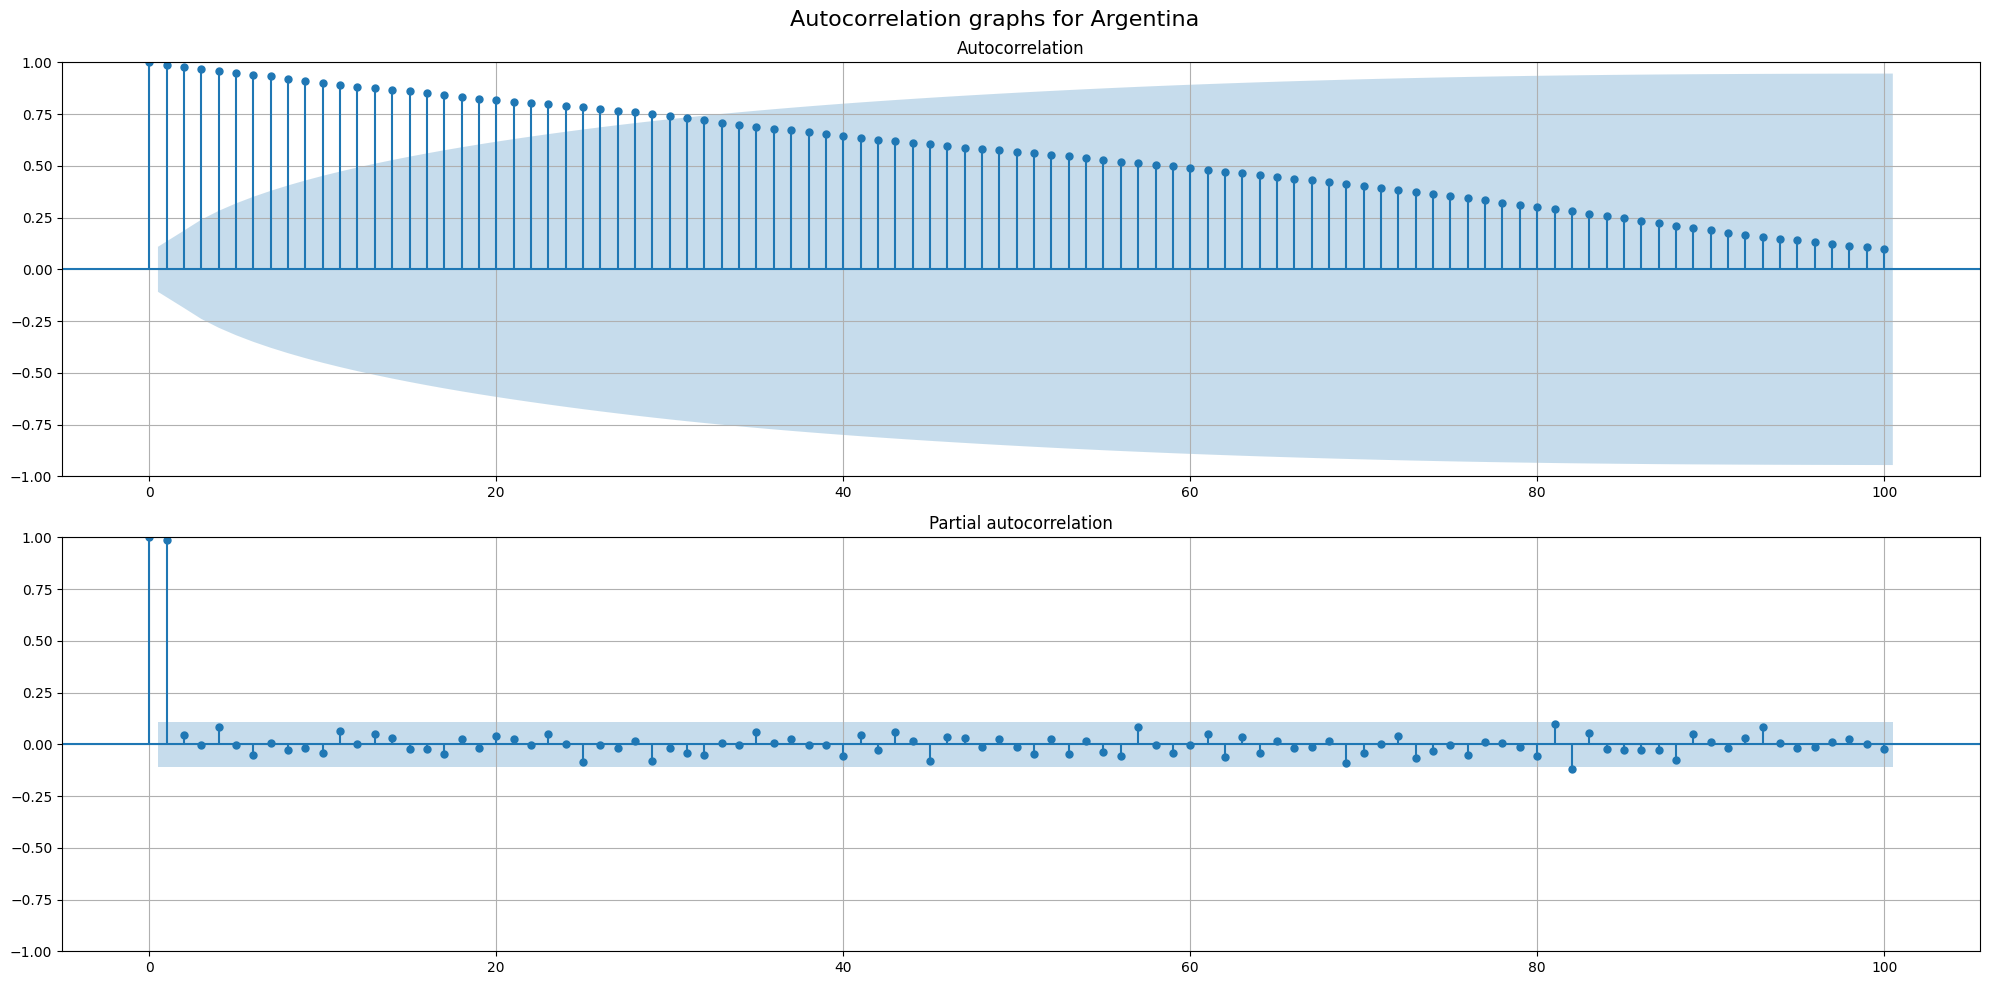

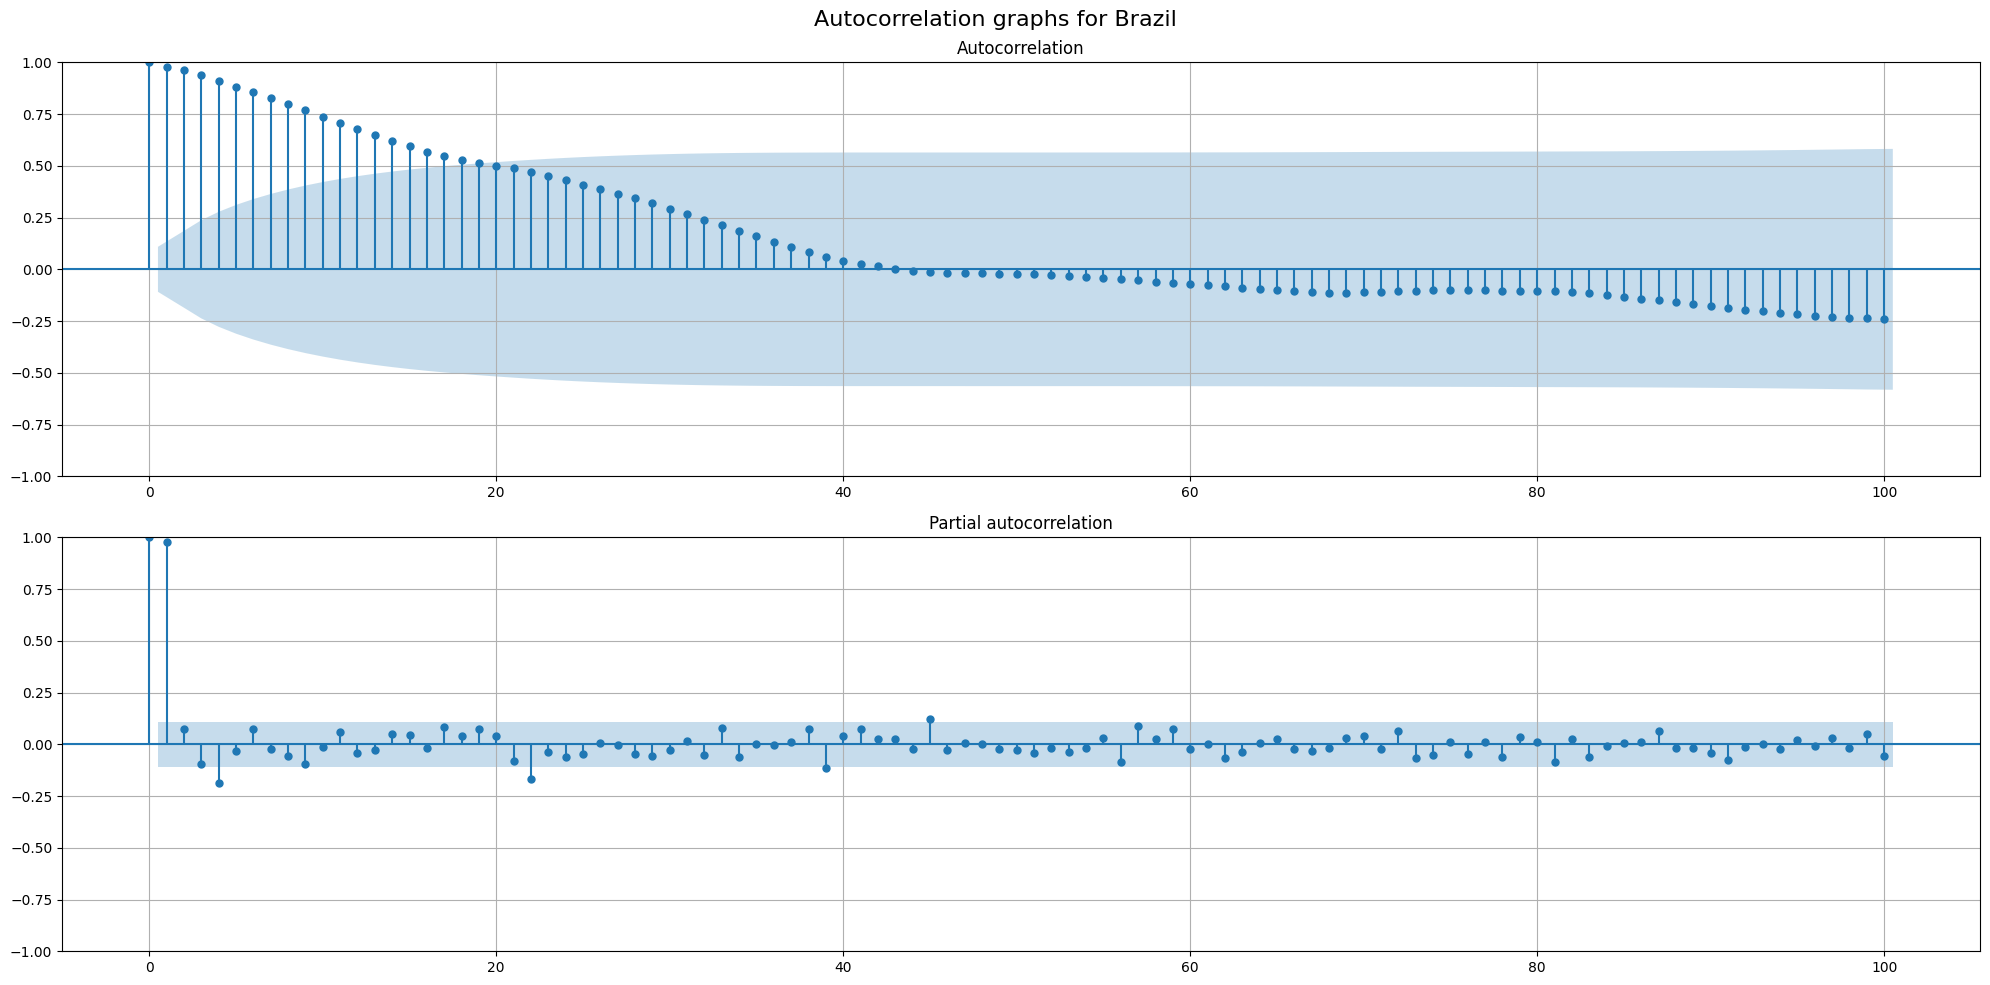

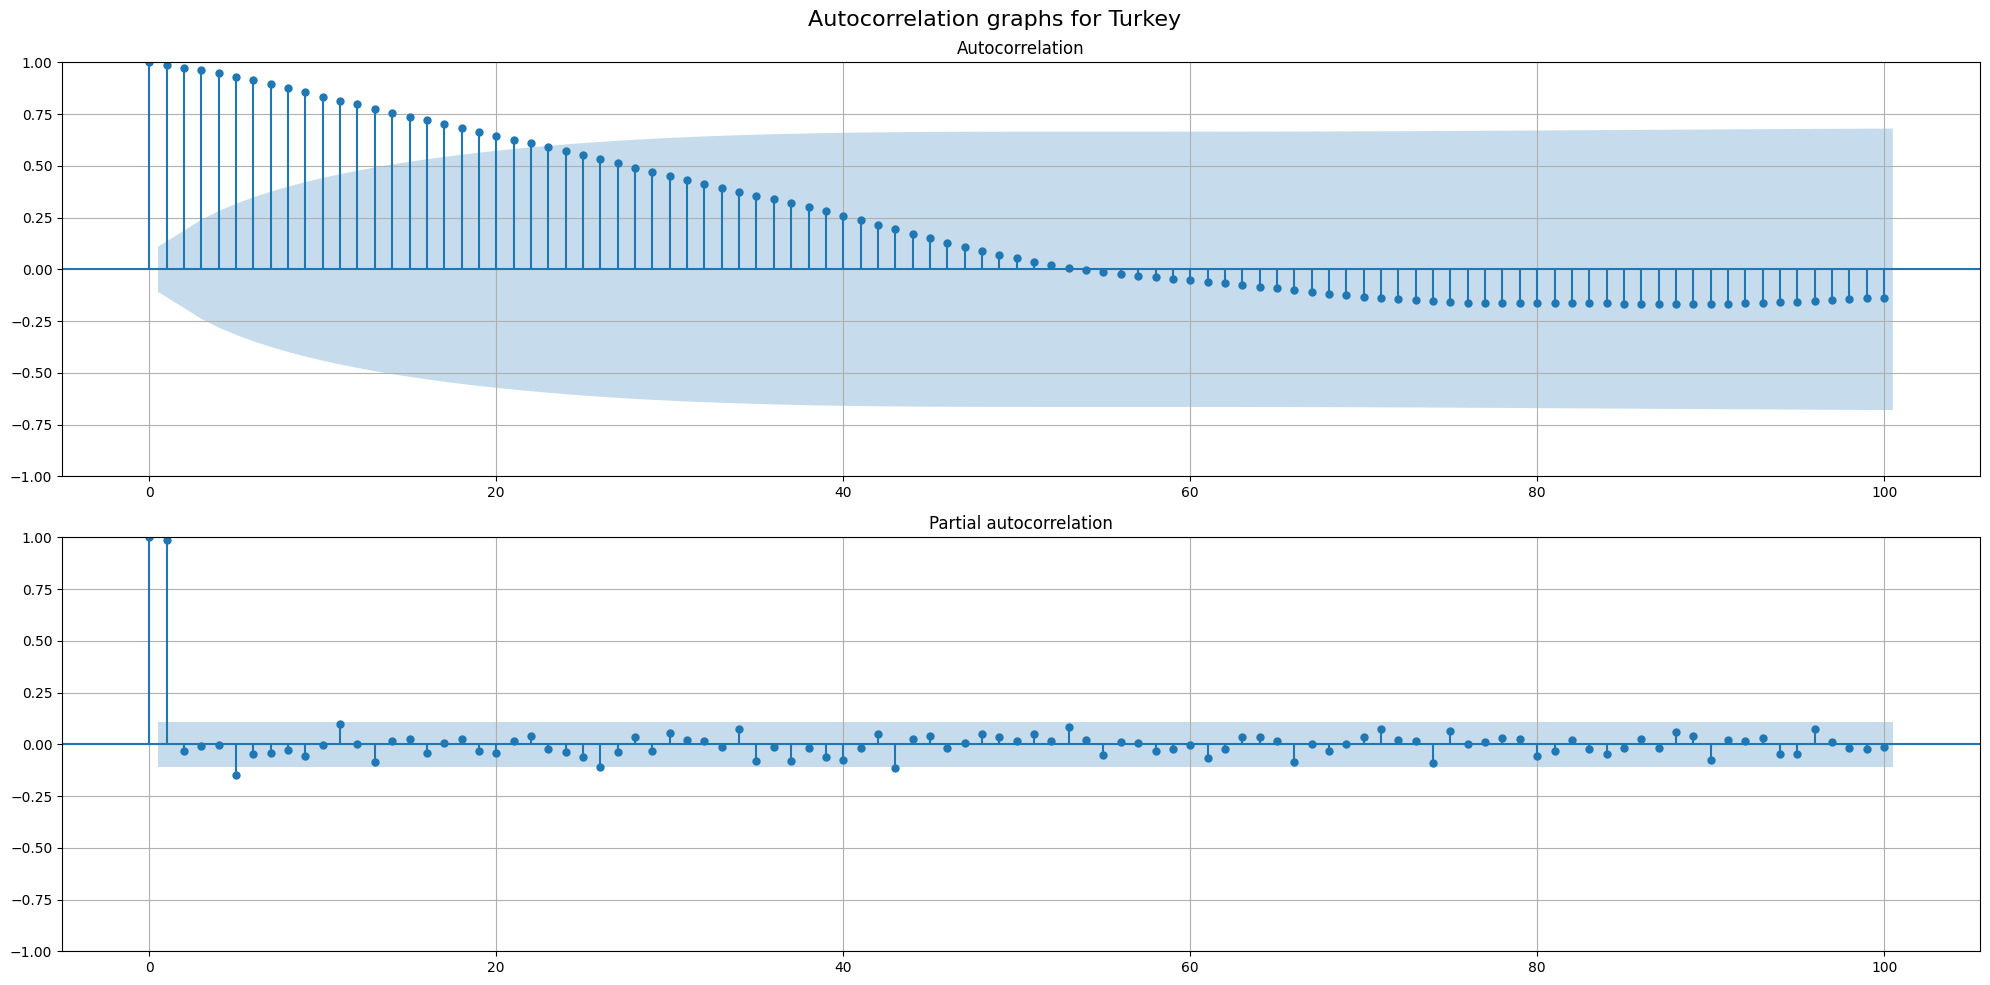

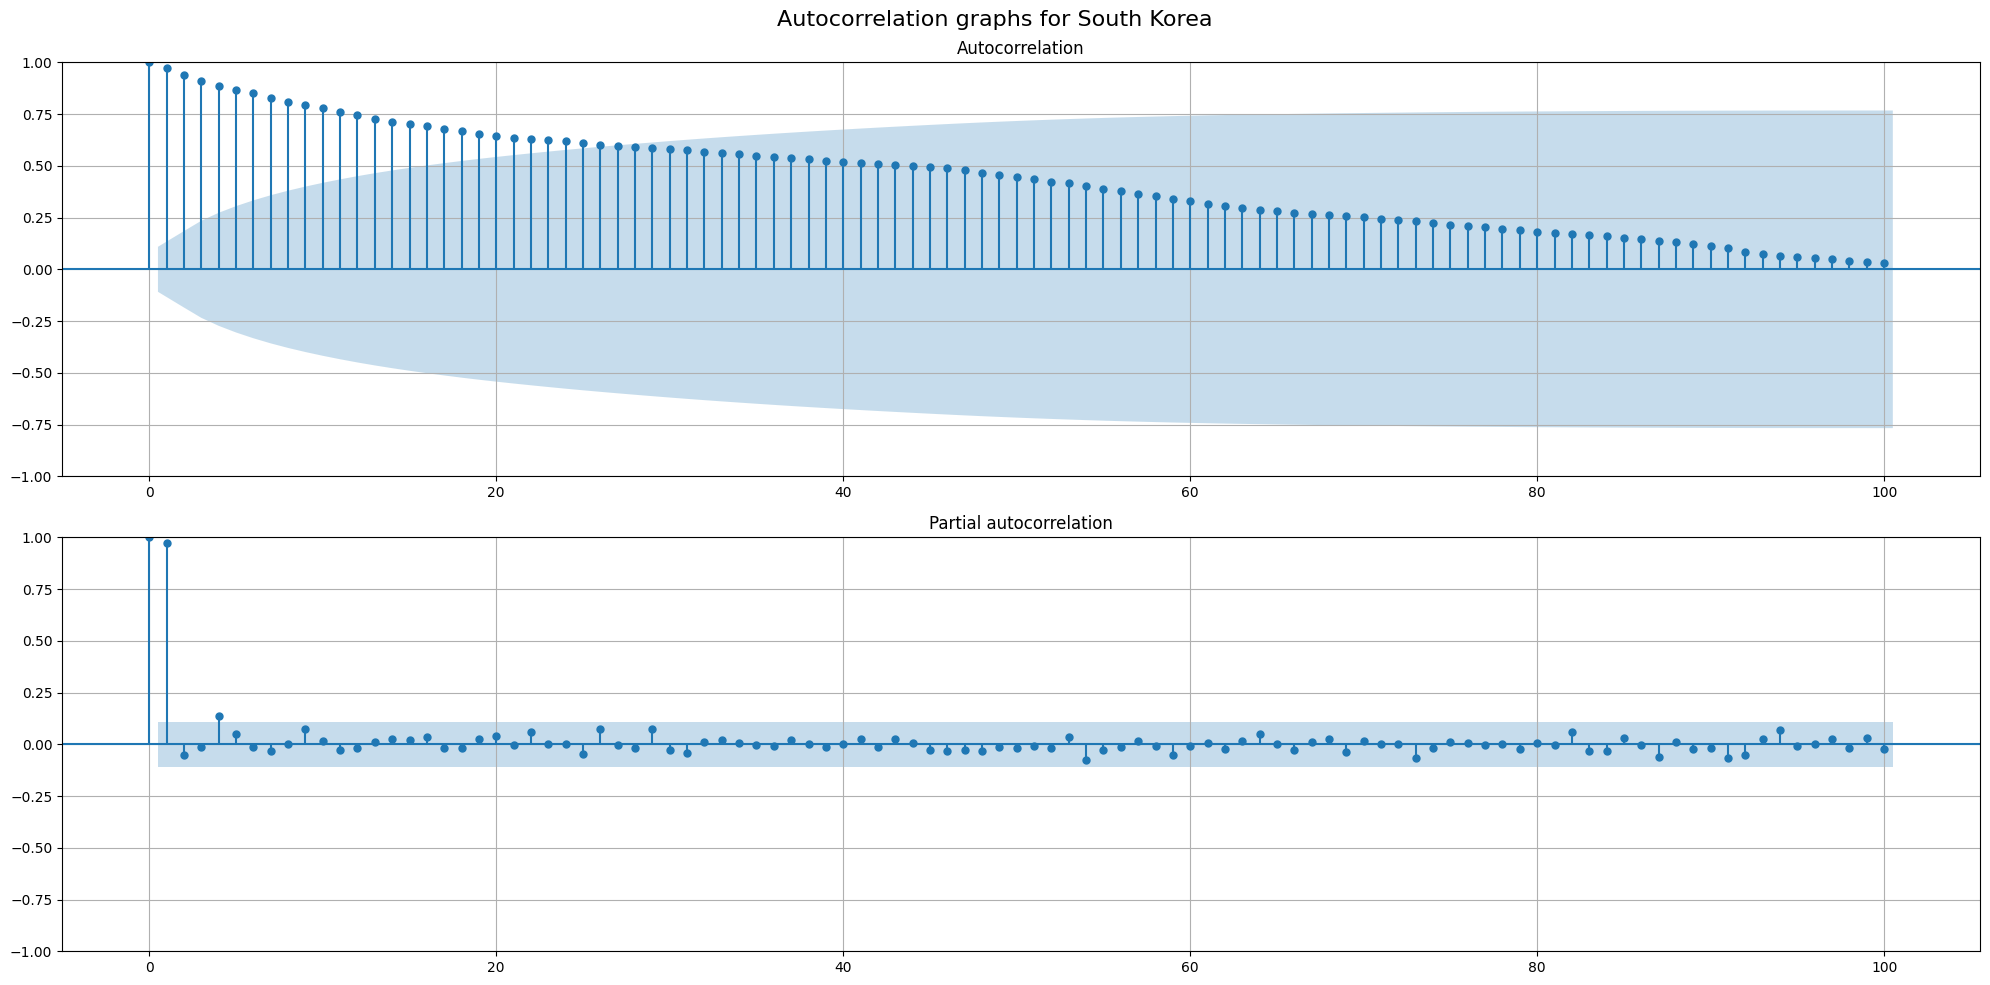

In [9]:
for key in data.keys():

  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
  # Plot the price autocorrelation in subplot 1
  sm.graphics.tsa.plot_acf(data[key]['Price'], lags=100, ax=axes[0])
  axes[0].set_title('Autocorrelation')
  axes[0].grid('on')

  # Plot the Change % in subplot 2
  sm.graphics.tsa.plot_pacf(data[key]['Price'], lags=100, ax=axes[1])
  axes[1].set_title('Partial autocorrelation')
  axes[1].grid('on')

  # set the figure title
  fig.suptitle(f'Autocorrelation graphs for {key}', fontsize=16)

  plt.tight_layout()
  plt.show()

we observe **strong autocorrelation** at low lags for the Price time series.

On the other hand, all the time series show **high partial autocorrelation** at lag 1, and it drops drastically starting from lag 2.

This is expected, given the highly unpredictable nature of the stock market: the last day price influence the current price - but all the others have little to no influence

# EDA - Exogenous variables correlation

In [11]:
for key in data.keys():
  print(f'Correlation between the {key} stock Price and the other variables:')
  for col in data[key].columns.values[1:]:
    corr = data[key]['Price'].corr(data[key][col])
    print(f'{col}: {corr}')
  print('\n######################\n')

Correlation between the South Africa stock Price and the other variables:
Open: 0.9918777213299957
High: 0.9965407033100059
Low: 0.9969677487655202
Vol.: -0.39399016619426613
Change %: 0.06768591702562866

######################

Correlation between the Russia stock Price and the other variables:
Open: 0.9923732435986713
High: 0.9965856814455504
Low: 0.995875324737219
Vol.: -0.244546734293683
Change %: 0.09200710348356822

######################

Correlation between the Colombia stock Price and the other variables:
Open: 0.9913668563003492
High: 0.995163445923214
Low: 0.9965031518548016
Vol.: -0.11134662565618071
Change %: 0.002658563514734509

######################

Correlation between the Egypt stock Price and the other variables:
Open: 0.9951251052583768
High: 0.9982092764957374
Low: 0.9974903184356135
Vol.: -0.26667457973206576
Change %: 0.08073916847058357

######################

Correlation between the Argentina stock Price and the other variables:
Open: 0.9929631531964603
High

We notice that there is **very high correlation** between price and Open, High and Low (as expected).

On the other hand, the Volume and the Change % have very little correlation with the Price - with the actual value changing based on the country.

Hopefully, the extended ARIMA model will pick up these correlations.

The Volume and Change % have a low correlation with the Price.

Probably they are correlated with each others, let's check:

In [16]:
for key in data.keys():

  corr = data[key]['Vol.'].corr(data[key]['Change %'])
  if key == 'South Africa':
    print(f'Correlation between Volume and Change % in {key}: {corr}')
  else:
    print(f'Correlation between Volume and Change % in {key}:\t  {corr}')

Correlation between Volume and Change % in South Africa: -0.06965848535208333
Correlation between Volume and Change % in Russia:	  0.040685239597573565
Correlation between Volume and Change % in Colombia:	  0.07416960383784278
Correlation between Volume and Change % in Egypt:	  0.1691261272100593
Correlation between Volume and Change % in Argentina:	  0.0397047831228635
Correlation between Volume and Change % in Brazil:	  0.11335376517189776
Correlation between Volume and Change % in Turkey:	  0.20341496467716785
Correlation between Volume and Change % in South Korea:	  0.23963395967475642


Contrary to what expected, the correlation is low.

Probably this is due to the extraordinary circumstances happening during the time period

# AutoARIMA

In [17]:
auto_models = {}

train_end = datetime(2020,12,31)

for key in data.keys():

  train_data = data[key]['Price'][:train_end]
  model = auto_arima(train_data)

  print(f'############################################################################\n\n{key.upper()}\n')
  print(model.summary())
  print('\n\n')
  auto_models[key] = model

############################################################################

SOUTH AFRICA

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2051.485
Date:                Sat, 23 Sep 2023   AIC                           4104.970
Time:                        12:10:24   BIC                           4108.531
Sample:                    01-02-2020   HQIC                          4106.402
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.162e+05   2.64e+04     15.784      0.000    3.65e+05    4.68e+05
Ljung-Box (L1) (Q):                   1

Save the ARIMA models trained with auto arima

In [18]:
with open('/content/gdrive/MyDrive/P5_files/trained_ARIMA.pkl', 'wb') as handle:
  pickle.dump(auto_models, handle)

In [8]:
with open('/content/gdrive/MyDrive/P5_files/trained_ARIMA.pkl', 'rb') as handle:
  auto_models = pickle.load(handle)

We notice that all of the models computed by the autoARIMA are fairly simple:
the maximum lag considered is 3.

This was expected from the EDA.

However, we further observe that the optimal moder of four countries (Argentina, Turkey, South Africa and South Korea) is a **simple integrator**

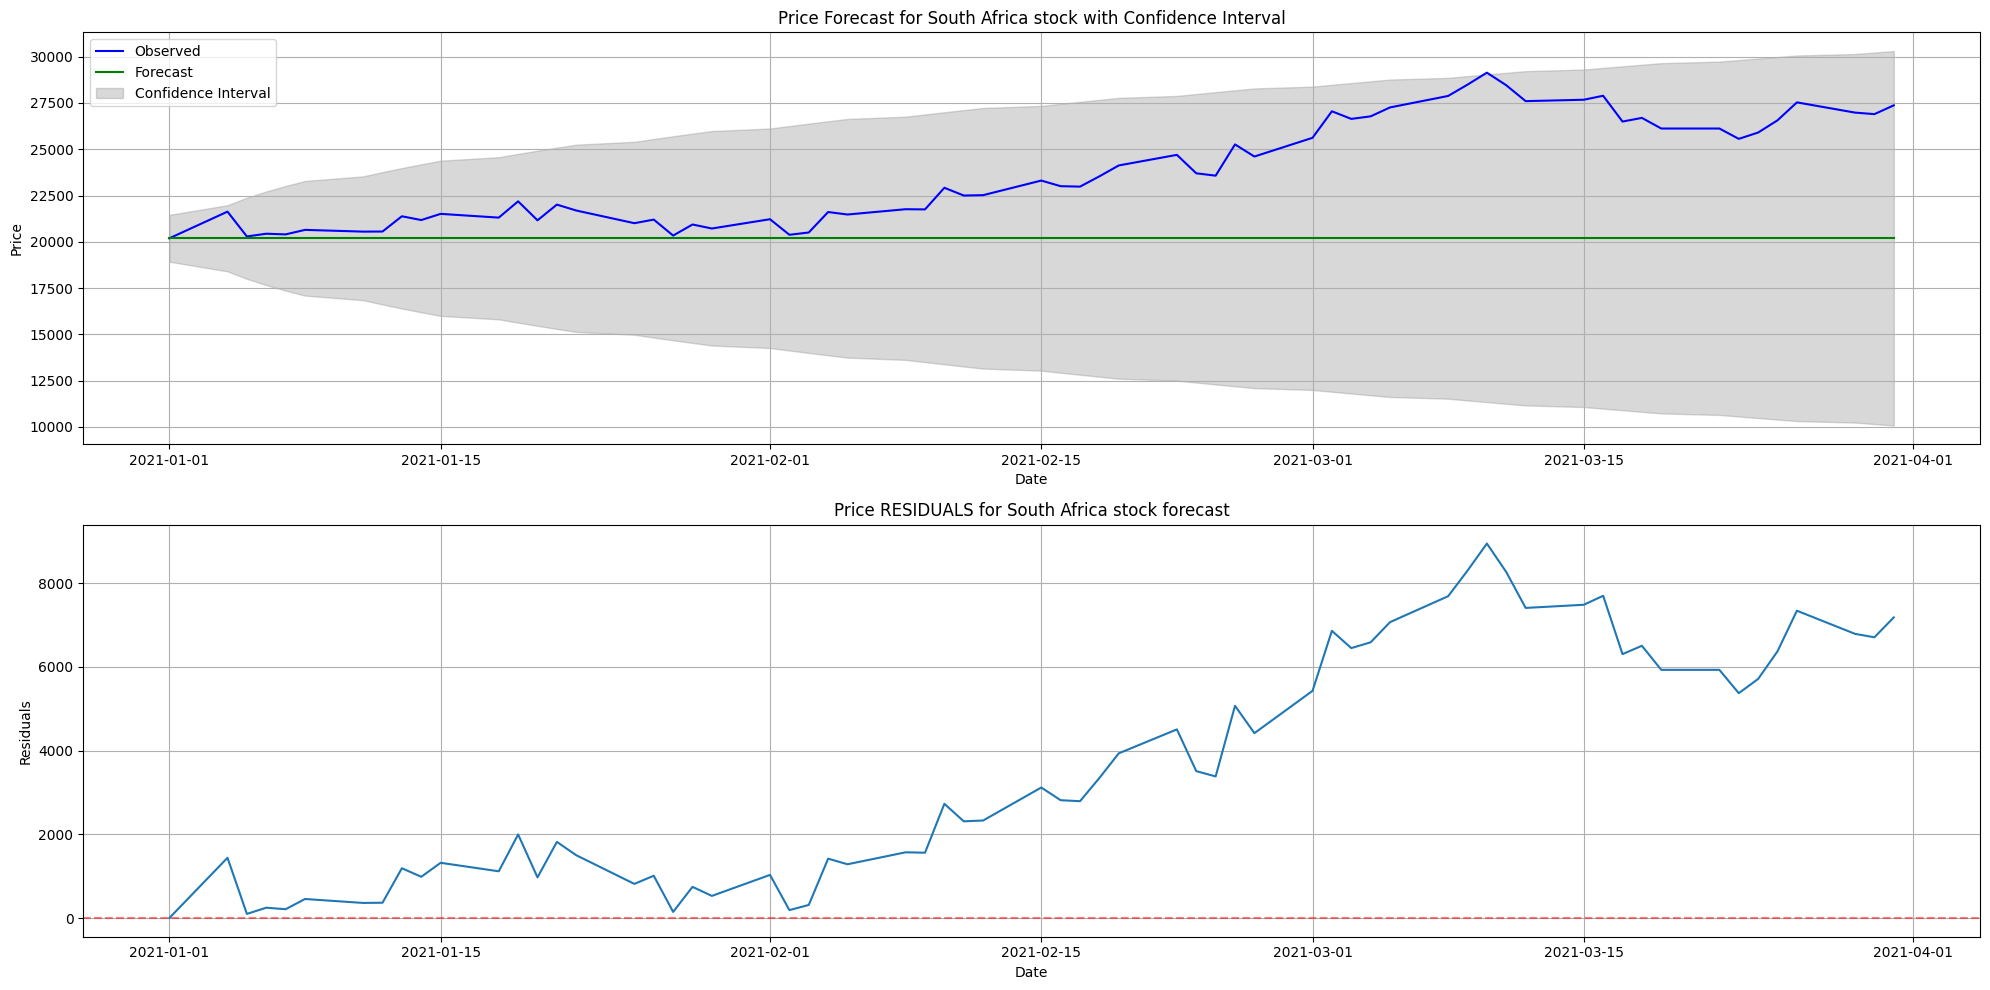

Mean Absolute Percent Error: 0.1382
Root Mean Squared Error: 4506.5862


##########################################################################################




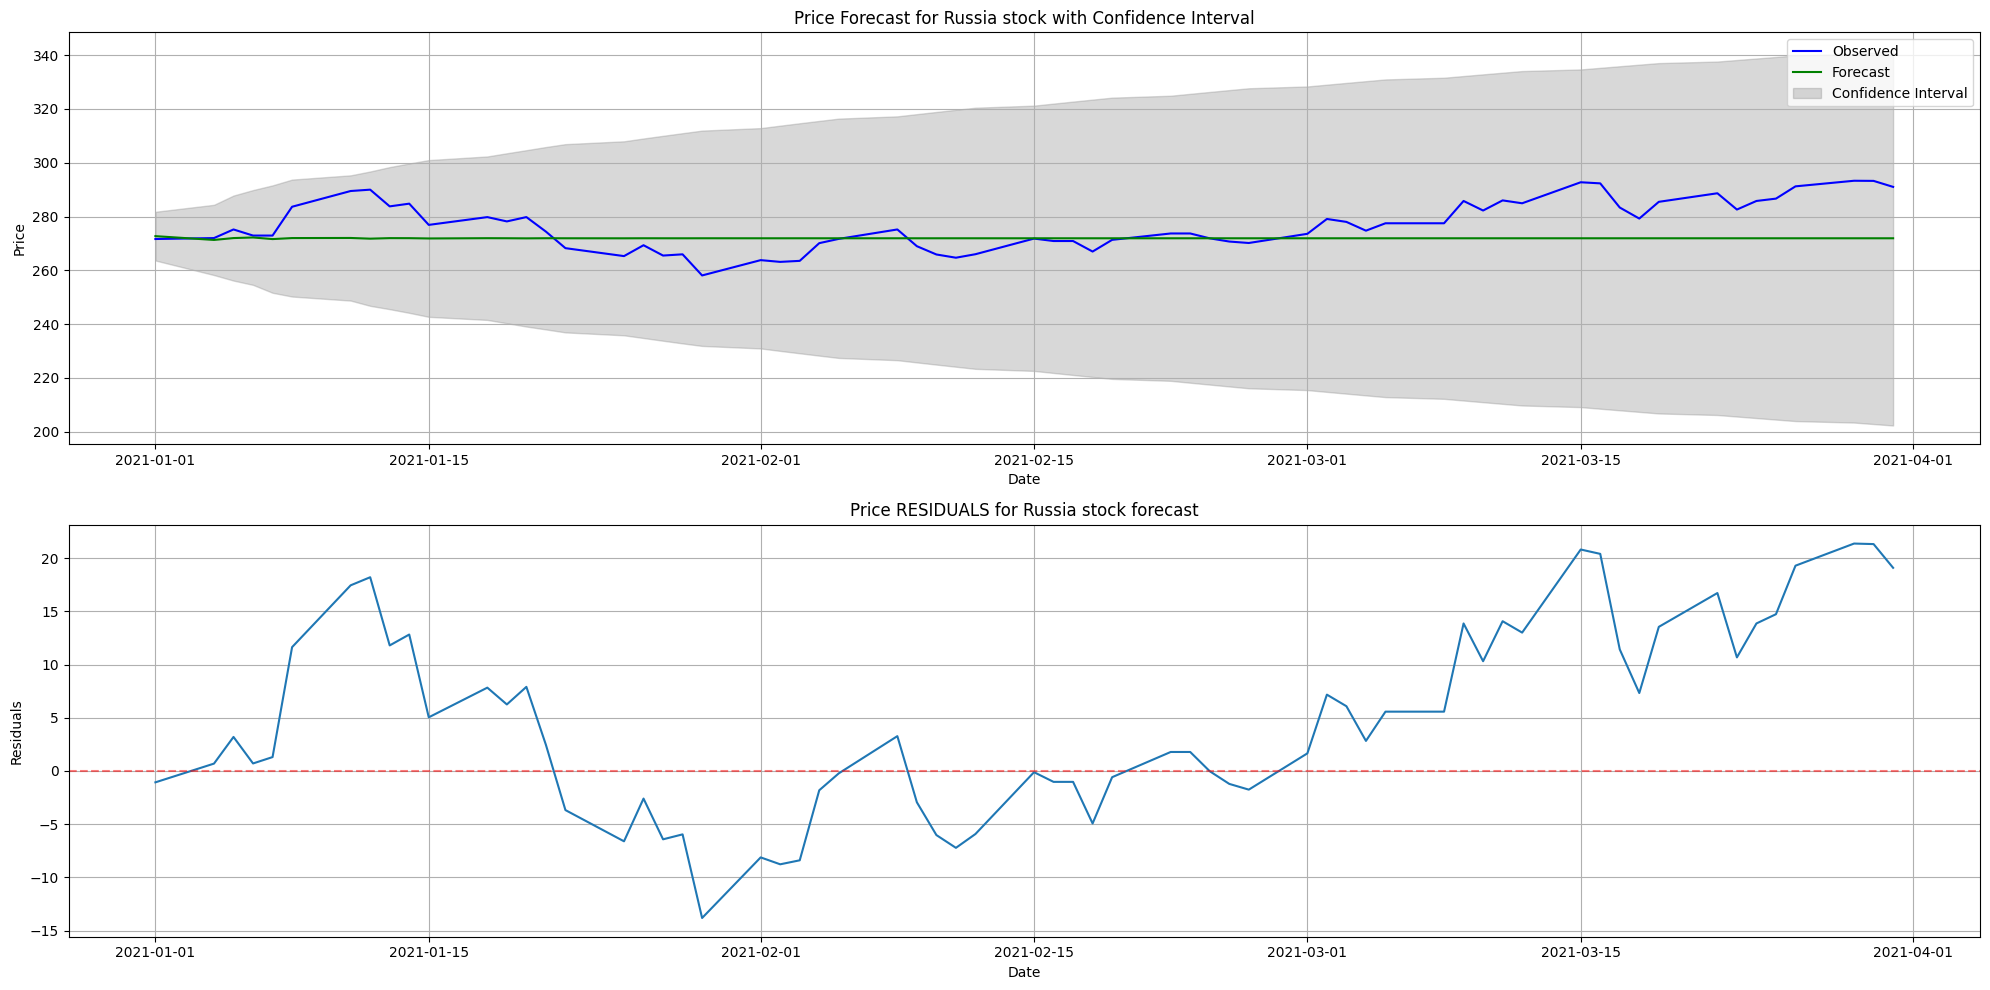

Mean Absolute Percent Error: 0.028
Root Mean Squared Error: 10.086


##########################################################################################




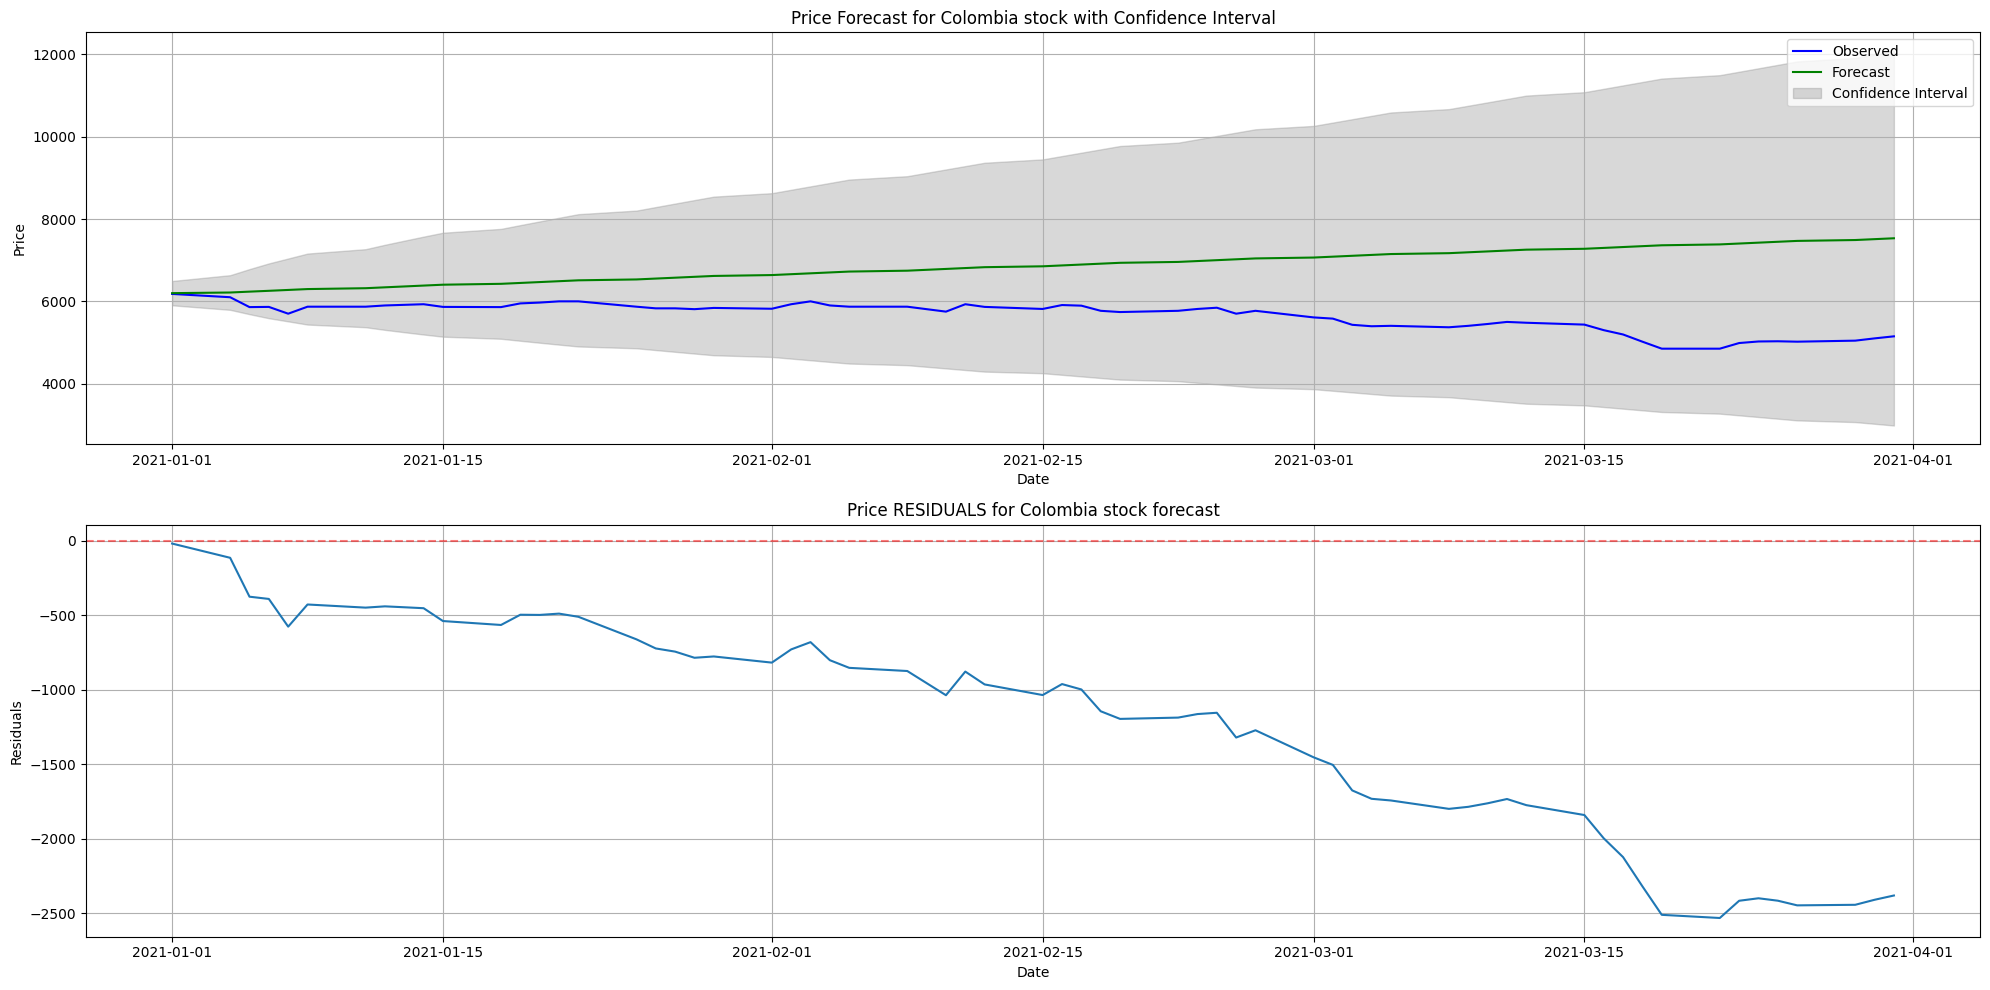

Mean Absolute Percent Error: 0.2236
Root Mean Squared Error: 1405.9814


##########################################################################################




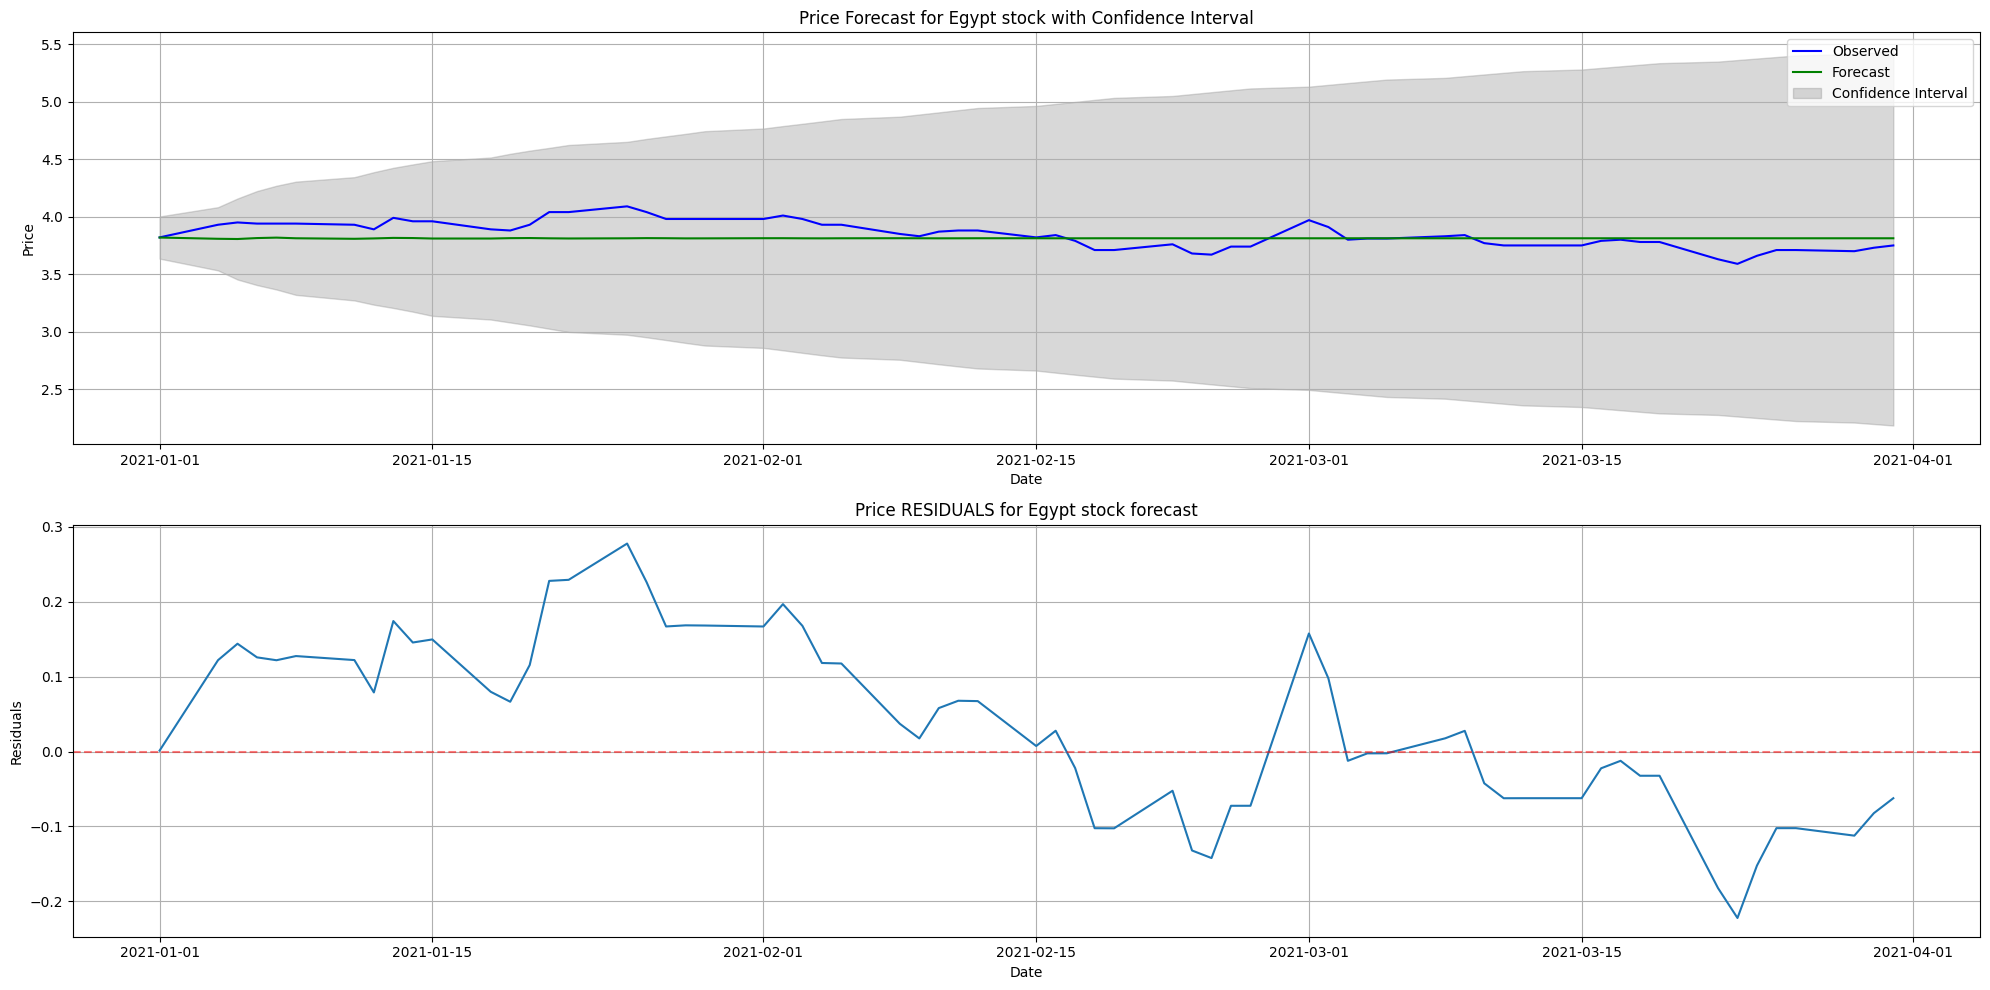

Mean Absolute Percent Error: 0.026
Root Mean Squared Error: 0.1207


##########################################################################################




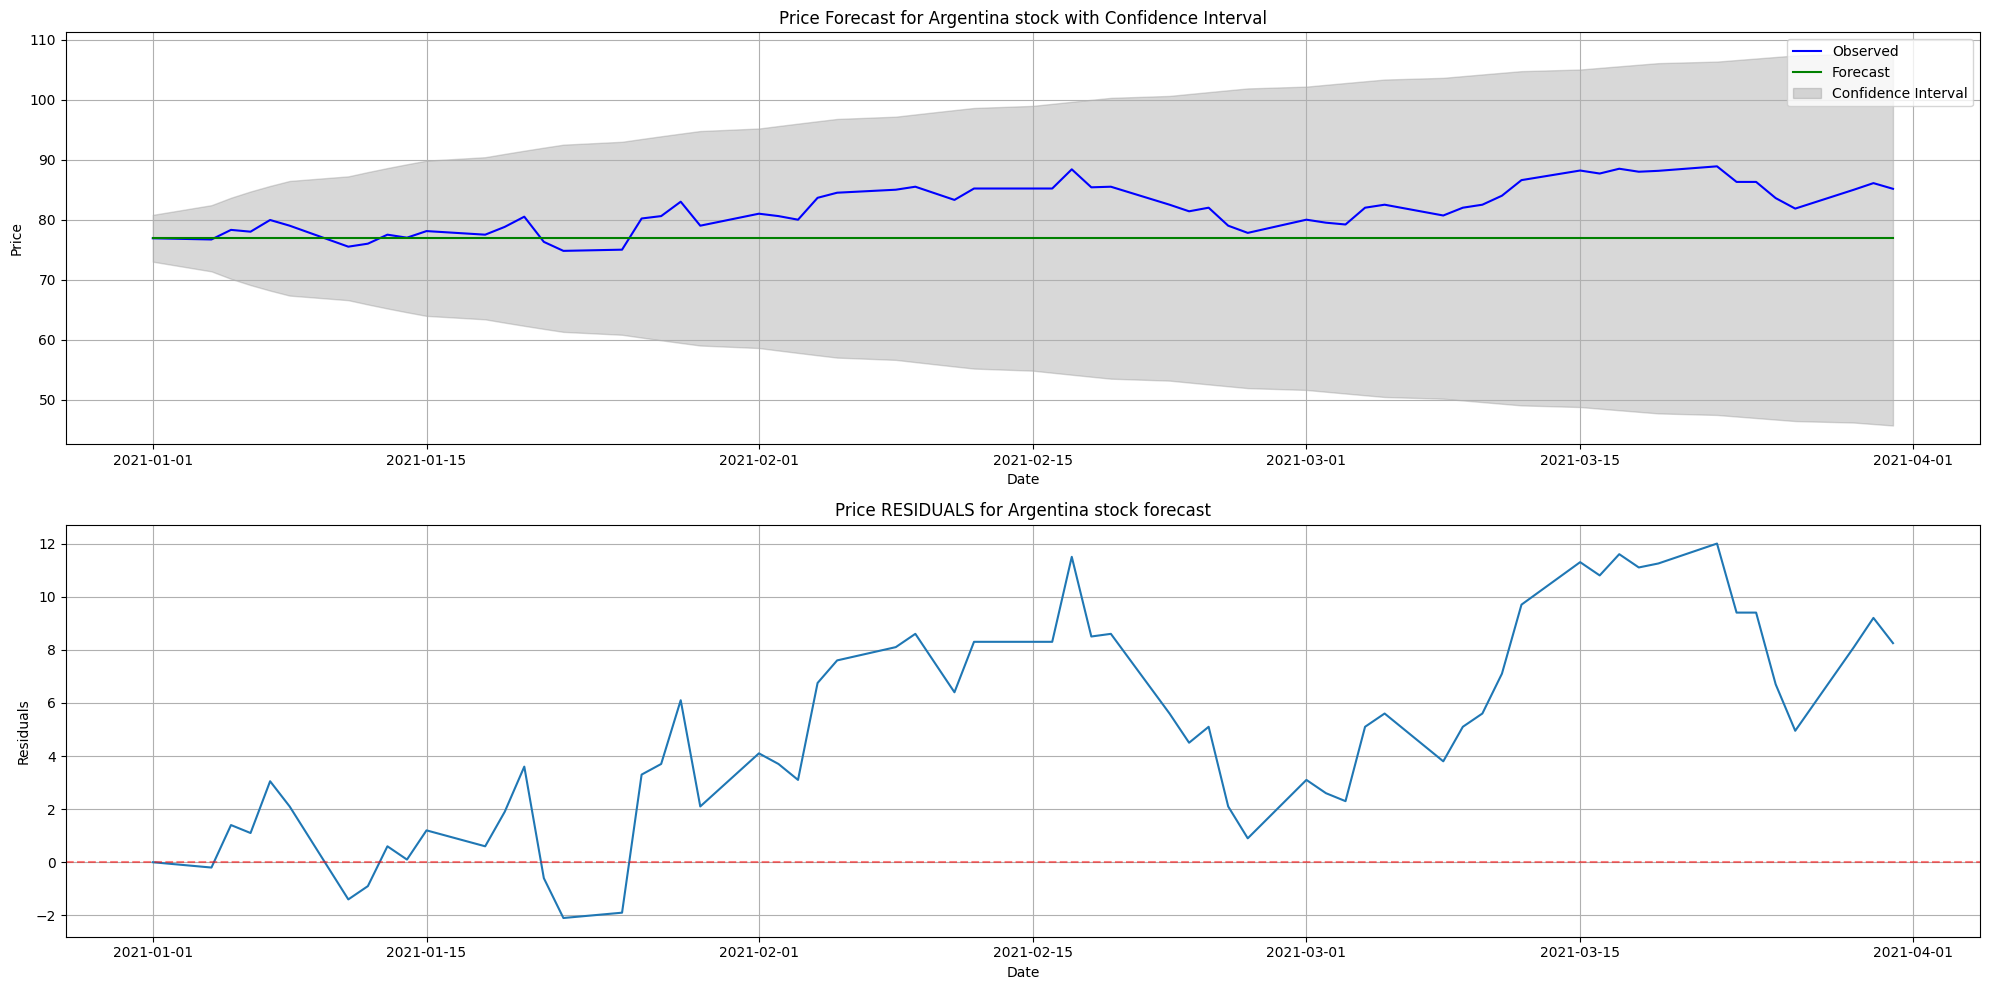

Mean Absolute Percent Error: 0.0629
Root Mean Squared Error: 6.366


##########################################################################################




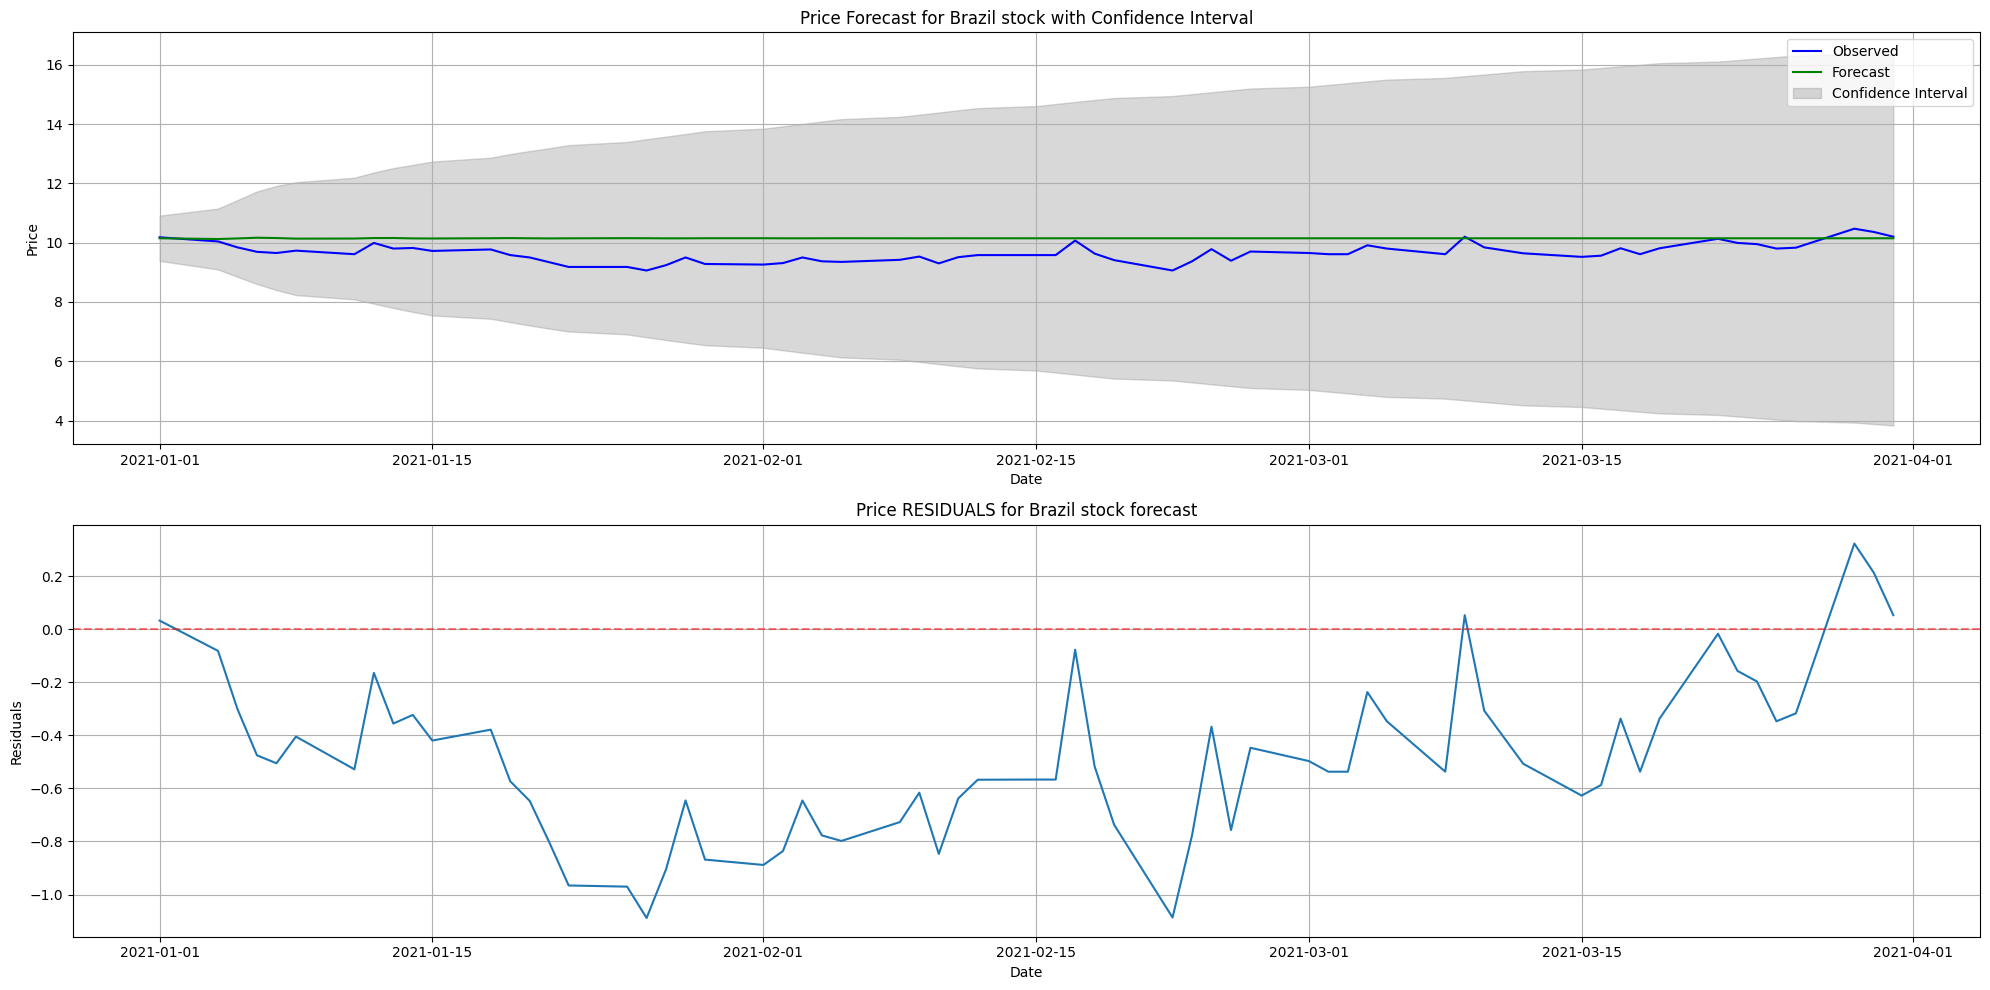

Mean Absolute Percent Error: 0.0538
Root Mean Squared Error: 0.5753


##########################################################################################




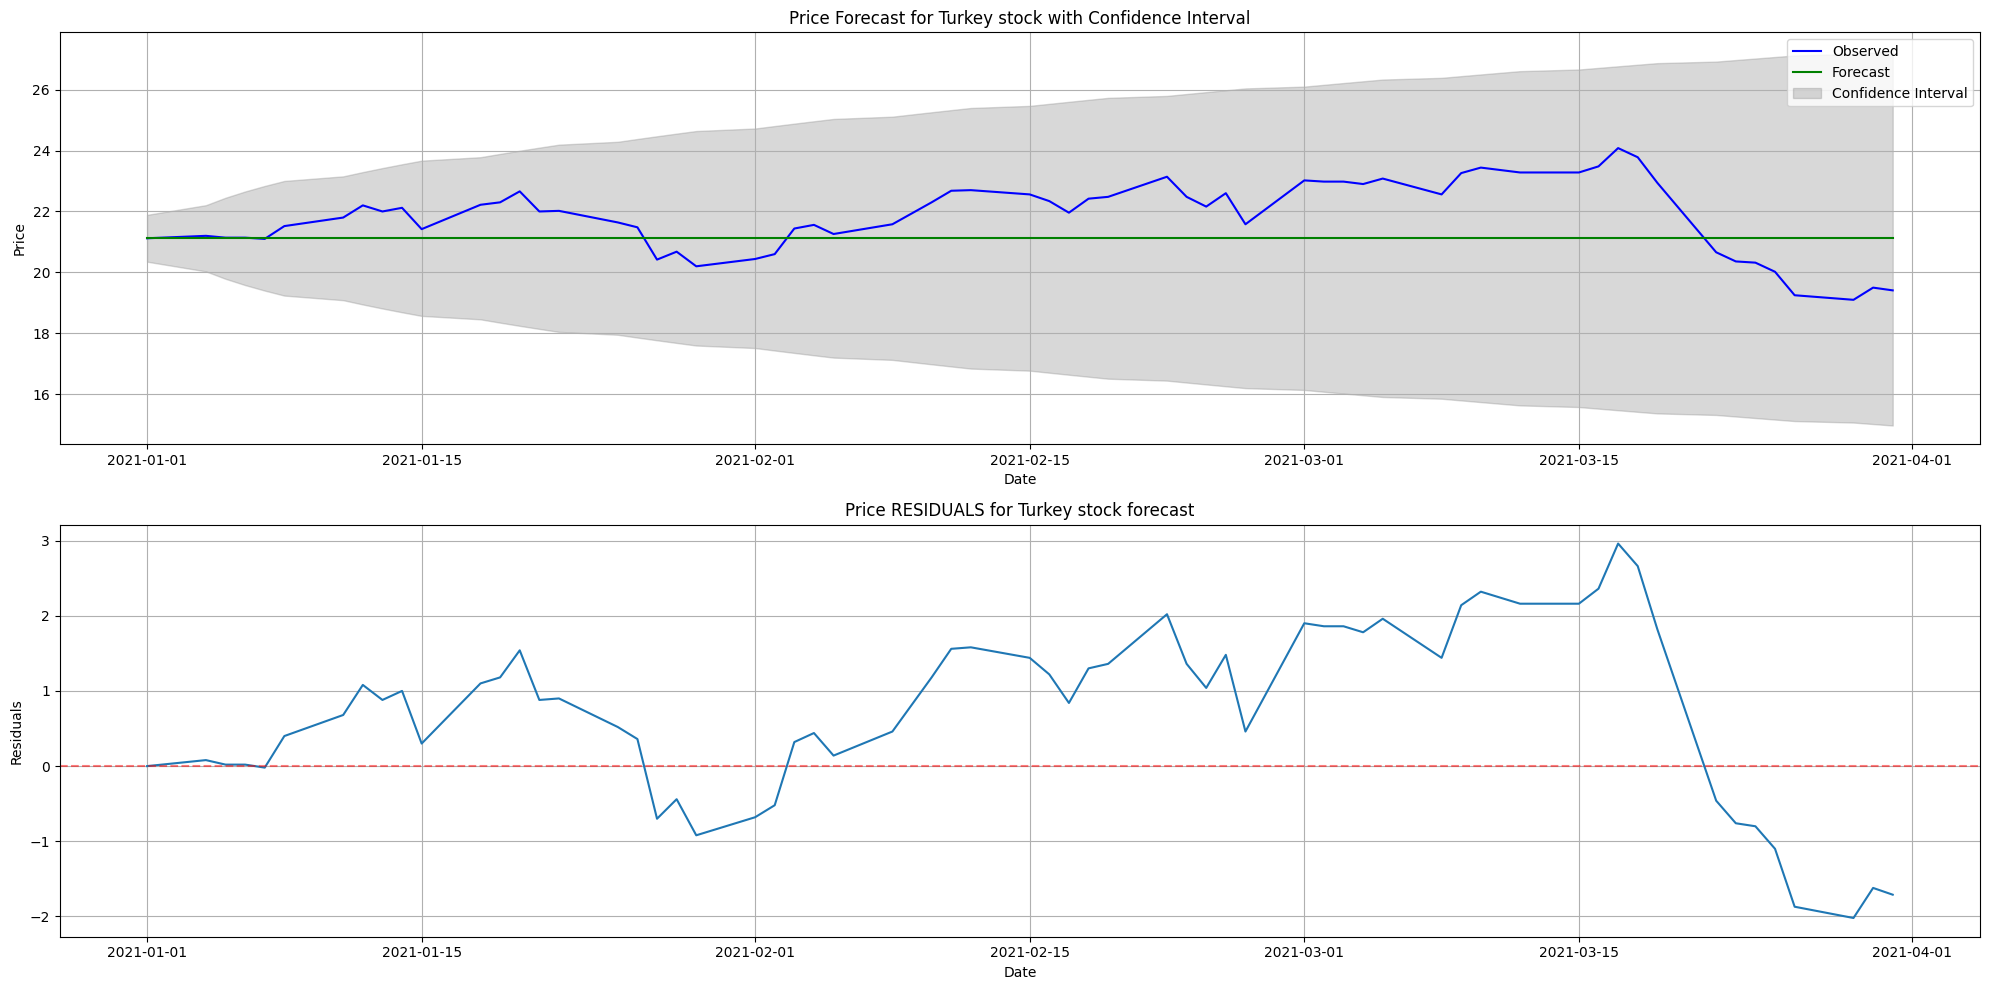

Mean Absolute Percent Error: 0.053
Root Mean Squared Error: 1.3809


##########################################################################################




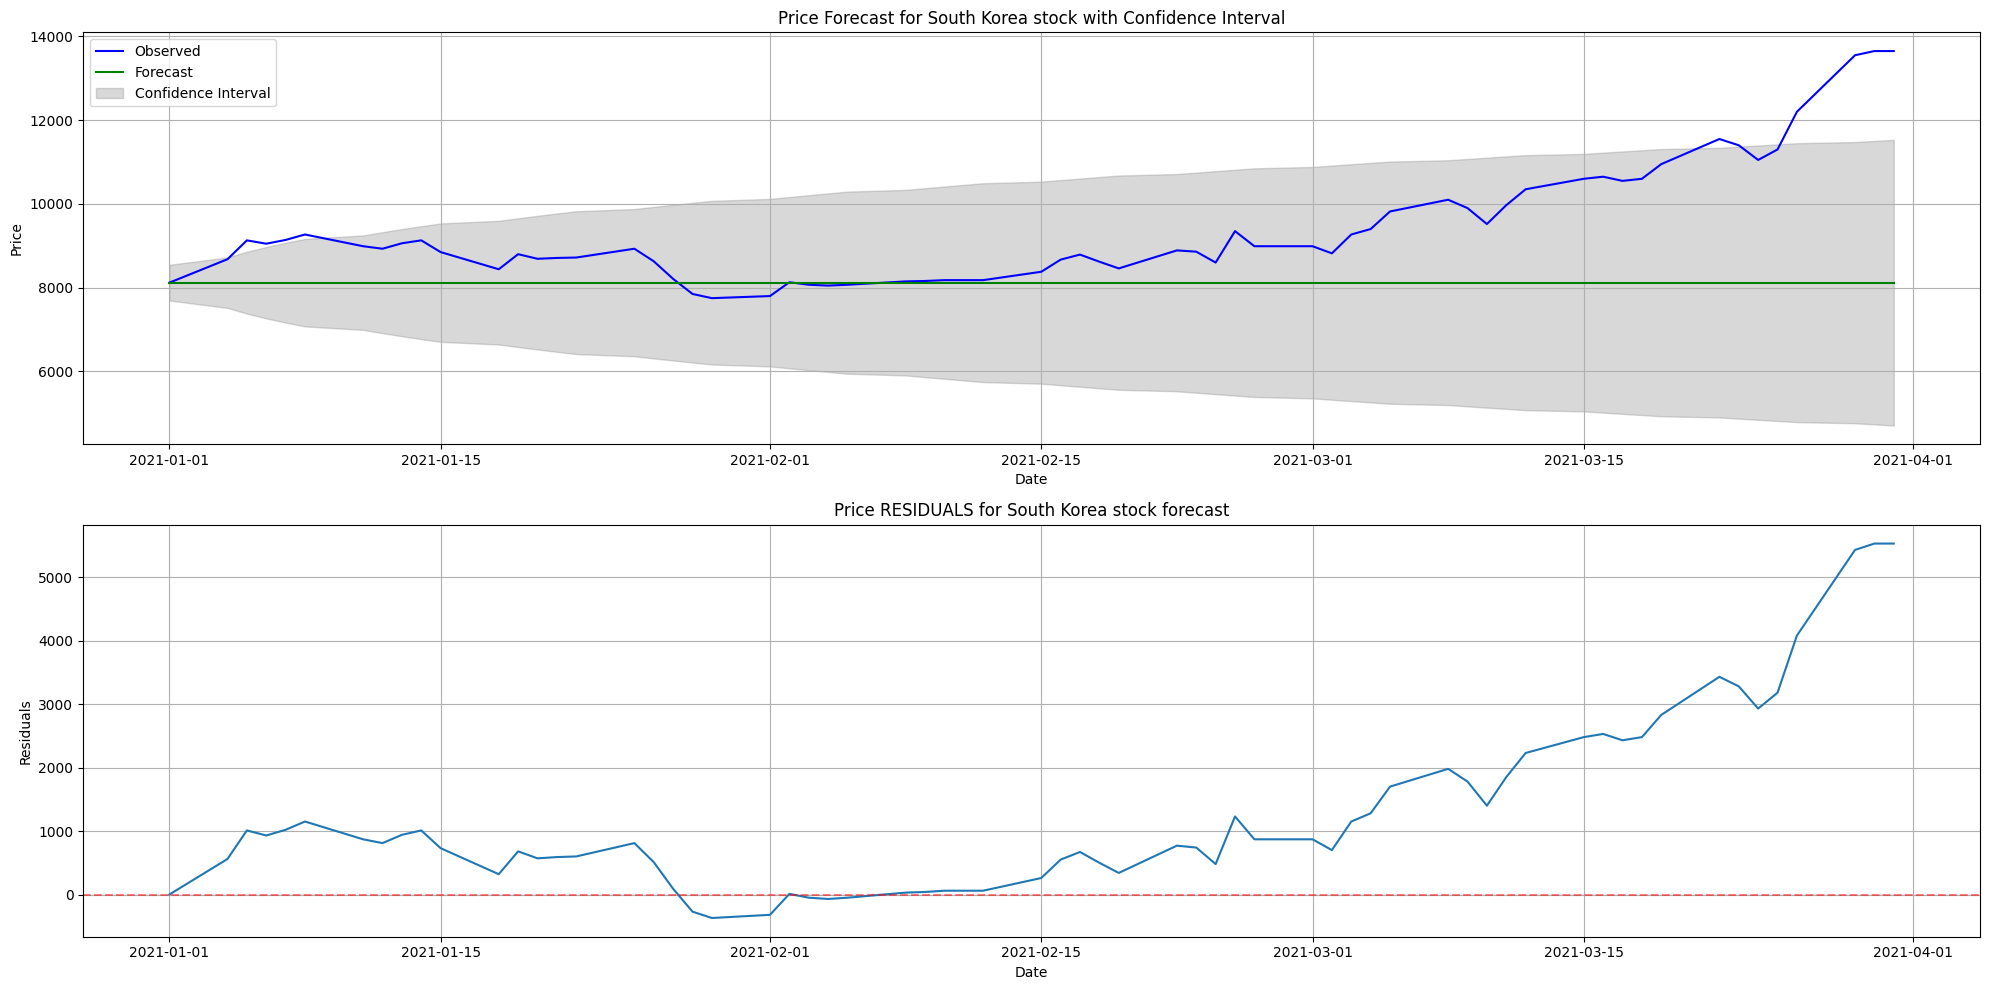

Mean Absolute Percent Error: 0.1216
Root Mean Squared Error: 1861.4729


##########################################################################################




In [19]:
# The column names indicate which exogenous variable we are considering;
# Price = no exo variable
# All = all exo variables
performance = pd.DataFrame(columns=['Country', 'Error', 'Price', 'All', 'Open', 'High', 'Low', 'Vol.', 'Change %'])
performance.set_index(['Country', 'Error'], inplace=True)
train_end = datetime(2020,12,31)

for key in data.keys():

  train_set = data[key]['Price'][:train_end]
  test_set = data[key]['Price'][train_end + timedelta(days=1):]

  n_forecast_periods = len(test_set)

  forecast, conf_int = auto_models[key].predict(n_periods=n_forecast_periods, return_conf_int=True)

  residuals = test_set - forecast

  # Plot the observed data
  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
  axes[0].plot(test_set, label='Observed', color='blue')

  # Plot the forecasts and confidence intervals
  axes[0].plot(forecast, label='Forecast', color='green')
  axes[0].fill_between(forecast.index, conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.3, label='Confidence Interval')

  # Customize the plot
  axes[0].set_title(f'Price Forecast for {key} stock with Confidence Interval')
  axes[0].set_xlabel('Date')
  axes[0].set_ylabel('Price')
  axes[0].legend()
  axes[0].grid(True)

  axes[1].plot(residuals)
  axes[1].axhline(y=0, color='red',  alpha=0.5, linestyle='--')

  # Customize the plot
  axes[1].set_title(f'Price RESIDUALS for {key} stock forecast')
  axes[1].set_xlabel('Date')
  axes[1].set_ylabel('Residuals')
  axes[1].grid(True)

  # Show the plot
  plt.tight_layout()
  plt.show()

  mape = round(np.mean(abs(residuals/test_set)), 4)
  rmse = round(np.sqrt(np.mean(residuals**2)), 4)

  new_row_index = pd.MultiIndex.from_tuples([(key, 'mape')], names=['Country', 'Error'])
  new_row_mape = pd.DataFrame([mape], columns=['Price'], index=new_row_index)

  new_row_index = pd.MultiIndex.from_tuples([(key, 'rmse')], names=['Country', 'Error'])
  new_row_rmse = pd.DataFrame([rmse], columns=['Price'], index=new_row_index)
  performance = pd.concat([performance, new_row_mape, new_row_rmse], ignore_index=False)

  print('Mean Absolute Percent Error:', mape)
  print('Root Mean Squared Error:', rmse)
  print('\n\n##########################################################################################\n\n')

In [20]:
with open('/content/gdrive/MyDrive/P5_files/performance.pkl', 'wb') as handle:
  pickle.dump(performance, handle)

# ARIMAX - Exogenous variables - last value

In [9]:
with open('/content/gdrive/MyDrive/P5_files/performance.pkl', 'rb') as handle:
  performance = pickle.load(handle)

In [ ]:
with open('/content/gdrive/MyDrive/P5_files/trained_ARIMA.pkl', 'rb') as handle:
  auto_models = pickle.load(handle)

In [41]:
import warnings

# Filter out specific warning messages
warnings.filterwarnings("ignore")

train_end = datetime(2020,12,31)
plot = False
arimax_models = {}

# For each time series
for key in data.keys():
  # We compute the model and result with a single exogenous variable

  country_arimax_models = {}

  # for all the exogenous variables
  for exo_var in performance.columns:

    train_set = data[key]['Price'][:train_end]
    test_set = data[key]['Price'][train_end + timedelta(days=1):]

    # Create the test data range for later use
    start_test = train_end + timedelta(days=1)
    end_test = data[key]['Price'].index[-1]
    date_range = pd.date_range(start=start_test, end=end_test, freq='B')

    if exo_var == 'Price':
      continue

    if exo_var == 'All':

      train_exo = data[key][:train_end]
      train_exo = train_exo.drop('Price', axis=1)

      # Build the exo variables based on the last known data
      last_value = train_exo.iloc[-1].values
      exo_data = dict(zip(train_exo.columns, last_value))
      test_exo = pd.DataFrame(exo_data, index=date_range)

    else:

      train_exo = data[key][exo_var][:train_end]

      # Build the test exo_var using the last known value
      last_value = train_exo[-1]
      test_exo = pd.Series(last_value, index=date_range)

    # get the optimal order computed by auto ARIMA
    order = auto_models[key].order

    # create the model and fit it
    model = sm.tsa.SARIMAX(train_set, order=order, exog=train_exo)
    sarimax = model.fit()

    # store the trained model in a dictionary
    country_arimax_models[exo_var] = sarimax

    # compute the forecast & the residuals
    n_forecast_periods = len(test_set)

    forecast_results = sarimax.get_forecast(steps=n_forecast_periods, exog=test_exo)
    forecast = forecast_results.predicted_mean
    conf_int = forecast_results.conf_int()

    residuals = test_set - forecast

    # Compute and store the performance metrics
    mape = round(np.mean(abs(residuals/test_set)), 4)
    rmse = round(np.sqrt(np.mean(residuals**2)), 4)

    performance.loc[(key, 'mape'), exo_var] = mape
    performance.loc[(key, 'rmse'), exo_var] = rmse

    if plot:
      # Plot the observed data
      fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
      axes[0].plot(test_set, label='Observed', color='blue')

      # Plot the forecasts and confidence intervals
      axes[0].plot(forecast, label='Forecast', color='green')
      axes[0].fill_between(forecast.index, conf_int['lower Price'], conf_int['upper Price'], color='gray', alpha=0.3, label='Confidence Interval')

      # Customize the plot
      axes[0].set_title(f'Price Forecast for {key} stock with Confidence Interval')
      axes[0].set_xlabel('Date')
      axes[0].set_ylabel('Price')
      axes[0].legend()
      axes[0].grid(True)

      axes[1].plot(residuals)
      axes[1].axhline(y=0, color='red',  alpha=0.5, linestyle='--')

      # Customize the plot
      axes[1].set_title(f'Price RESIDUALS for {key} stock forecast')
      axes[1].set_xlabel('Date')
      axes[1].set_ylabel('Residuals')
      axes[1].grid(True)

      # Show the plot
      plt.tight_layout()
      plt.show()

  arimax_models[key] = country_arimax_models

In [42]:
with open('/content/gdrive/MyDrive/P5_files/performance.pkl', 'wb') as handle:
  pickle.dump(performance, handle)

In [43]:
with open('/content/gdrive/MyDrive/P5_files/trained_SARIMAX.pkl', 'wb') as handle:
  pickle.dump(arimax_models, handle)

# Performance Analysis

In [5]:
with open('/content/gdrive/MyDrive/P5_files/performance.pkl', 'rb') as handle:
  performance = pickle.load(handle)

In [44]:
import plotly.graph_objects as go

for key in data.keys():
  tmp = performance.loc[key]

  fig = go.Figure()
  fig.add_trace(go.Bar(x=tmp.loc['mape'].index, y=tmp.loc['mape'].values))
  fig.update_layout(title=f'{key} - Mean Average Percent Error')
  fig.update_layout(width=1200, height=400)
  fig.show()

  fig = go.Figure()
  fig.add_trace(go.Bar(x=tmp.loc['rmse'].index, y=tmp.loc['rmse'].values, marker=dict(color='red')))
  fig.update_layout(title=f'{key} - Root Mean Square Error')
  fig.update_layout(width=1200, height=400)
  fig.show()

We notice that the introduction of exogenous variables have no effect on the performance.

Three countries show some effects of the exogenous variables:
- Brazil, performs worse
- Columbia, performs better
- Egypt, slightly better

If we look at the stationarity analysis done earlier, the recorded p-value of the price is low (0.1841, 0.1879, 0.2452 respectively), indicating an overall stationarity of the markets


# ARIMAX - Exogenous variables - last moving average value

In [ ]:
with open('/content/gdrive/MyDrive/P5_files/performance.pkl', 'rb') as handle:
  performance = pickle.load(handle)

In [ ]:
with open('/content/gdrive/MyDrive/P5_files/trained_ARIMA.pkl', 'rb') as handle:
  auto_models = pickle.load(handle)

In [50]:
import warnings

# Filter out specific warning messages
warnings.filterwarnings("ignore")

window_size = 20
ma_performance = performance.copy()

train_end = datetime(2020,12,31)
plot = False
ma_arimax_models = {}

# For each time series
for key in data.keys():
  # We compute the model and result with a single exogenous variable

  country_arimax_models = {}

  # for all the exogenous variables
  for exo_var in performance.columns:

    train_set = data[key]['Price'][:train_end]
    test_set = data[key]['Price'][train_end + timedelta(days=1):]

    # Create the test data range for later use
    start_test = train_end + timedelta(days=1)
    end_test = data[key]['Price'].index[-1]
    date_range = pd.date_range(start=start_test, end=end_test, freq='B')

    if exo_var == 'Price':
      continue

    if exo_var == 'All':

      train_exo = data[key][:train_end]
      train_exo = train_exo.drop('Price', axis=1)

      # Build the test exo_var using the last moving average value
      exo_rolling_mean = train_exo.rolling(window=window_size).mean()
      last_value = exo_rolling_mean.iloc[-1]
      exo_data = dict(zip(train_exo.columns, last_value))
      test_exo = pd.DataFrame(exo_data, index=date_range)

    else:

      train_exo = data[key][exo_var][:train_end]

      # Build the test exo_var using the last moving average value
      exo_rolling_mean = train_exo.rolling(window=window_size).mean()
      last_value = exo_rolling_mean[-1]
      test_exo = pd.Series(last_value, index=date_range)

    # get the optimal order computed by auto ARIMA
    order = auto_models[key].order

    # create the model and fit it
    model = sm.tsa.SARIMAX(train_set, order=order, exog=train_exo)
    sarimax = model.fit()

    # store the trained model in a dictionary
    country_arimax_models[exo_var] = sarimax

    # compute the forecast & the residuals
    n_forecast_periods = len(test_set)

    forecast_results = sarimax.get_forecast(steps=n_forecast_periods, exog=test_exo)
    forecast = forecast_results.predicted_mean
    conf_int = forecast_results.conf_int()

    residuals = test_set - forecast

    # Compute and store the performance metrics
    mape = round(np.mean(abs(residuals/test_set)), 4)
    rmse = round(np.sqrt(np.mean(residuals**2)), 4)

    ma_performance.loc[(key, 'mape'), exo_var] = mape
    ma_performance.loc[(key, 'rmse'), exo_var] = rmse

    if plot:
      # Plot the observed data
      fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
      axes[0].plot(test_set, label='Observed', color='blue')

      # Plot the forecasts and confidence intervals
      axes[0].plot(forecast, label='Forecast', color='green')
      axes[0].fill_between(forecast.index, conf_int['lower Price'], conf_int['upper Price'], color='gray', alpha=0.3, label='Confidence Interval')

      # Customize the plot
      axes[0].set_title(f'Price Forecast for {key} stock with Confidence Interval')
      axes[0].set_xlabel('Date')
      axes[0].set_ylabel('Price')
      axes[0].legend()
      axes[0].grid(True)

      axes[1].plot(residuals)
      axes[1].axhline(y=0, color='red',  alpha=0.5, linestyle='--')

      # Customize the plot
      axes[1].set_title(f'Price RESIDUALS for {key} stock forecast')
      axes[1].set_xlabel('Date')
      axes[1].set_ylabel('Residuals')
      axes[1].grid(True)

      # Show the plot
      plt.tight_layout()
      plt.show()

  ma_arimax_models[key] = country_arimax_models

In [51]:
with open('/content/gdrive/MyDrive/P5_files/ma_performance.pkl', 'wb') as handle:
  pickle.dump(ma_performance, handle)

In [52]:
with open('/content/gdrive/MyDrive/P5_files/ma_trained_SARIMAX.pkl', 'wb') as handle:
  pickle.dump(ma_arimax_models, handle)

# Performance Analysis - moving average

In [ ]:
with open('/content/gdrive/MyDrive/P5_files/ma_performance.pkl', 'rb') as handle:
  ma_performance = pickle.load(handle)

In [54]:
import plotly.graph_objects as go

for key in data.keys():
  tmp = ma_performance.loc[key]

  fig = go.Figure()
  fig.add_trace(go.Bar(x=tmp.loc['mape'].index, y=tmp.loc['mape'].values))
  fig.update_layout(title=f'{key} - Mean Average Percent Error')
  fig.update_layout(width=1200, height=400)
  fig.show()

  fig = go.Figure()
  fig.add_trace(go.Bar(x=tmp.loc['rmse'].index, y=tmp.loc['rmse'].values, marker=dict(color='red')))
  fig.update_layout(title=f'{key} - Root Mean Square Error')
  fig.update_layout(width=1200, height=400)
  fig.show()

Using the last moving average value rather then the last value have a **greater effect** on performance.

# Rolling Forecast Origin

In [5]:
with open('/content/gdrive/MyDrive/P5_files/trained_ARIMA.pkl', 'rb') as handle:
  auto_models = pickle.load(handle)

In [6]:
with open('/content/gdrive/MyDrive/P5_files/ma_performance.pkl', 'rb') as handle:
  ma_performance = pickle.load(handle)

First, we select the optimal combination of exogenous variables for each model.

From the analysis of the above graphs, we notice that the two error measures we consider show the same ranking of models.

In [8]:
ma_performance.loc[ma_performance.index.get_level_values('Error') =='mape'].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8 entries, ('South Africa', 'mape') to ('South Korea', 'mape')
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     8 non-null      float64
 1   All       8 non-null      object 
 2   Open      8 non-null      object 
 3   High      8 non-null      object 
 4   Low       8 non-null      object 
 5   Vol.      8 non-null      object 
 6   Change %  8 non-null      object 
dtypes: float64(1), object(6)
memory usage: 654.0+ bytes


In [9]:
for col in ma_performance.columns:
  ma_performance[col] = ma_performance[col].astype(float)

best_exo = ma_performance.loc[ma_performance.index.get_level_values('Error') =='mape'].apply(lambda x: x.idxmin(), axis=1)
best_exo = best_exo.reset_index(level='Error', drop=True)

In [10]:
best_exo

Country
South Africa    Vol.
Russia          High
Colombia        Open
Egypt           Vol.
Argentina       High
Brazil          Open
Turkey          Vol.
South Korea     Open
dtype: object

We need to predict the stock prices on a **daily** basis.



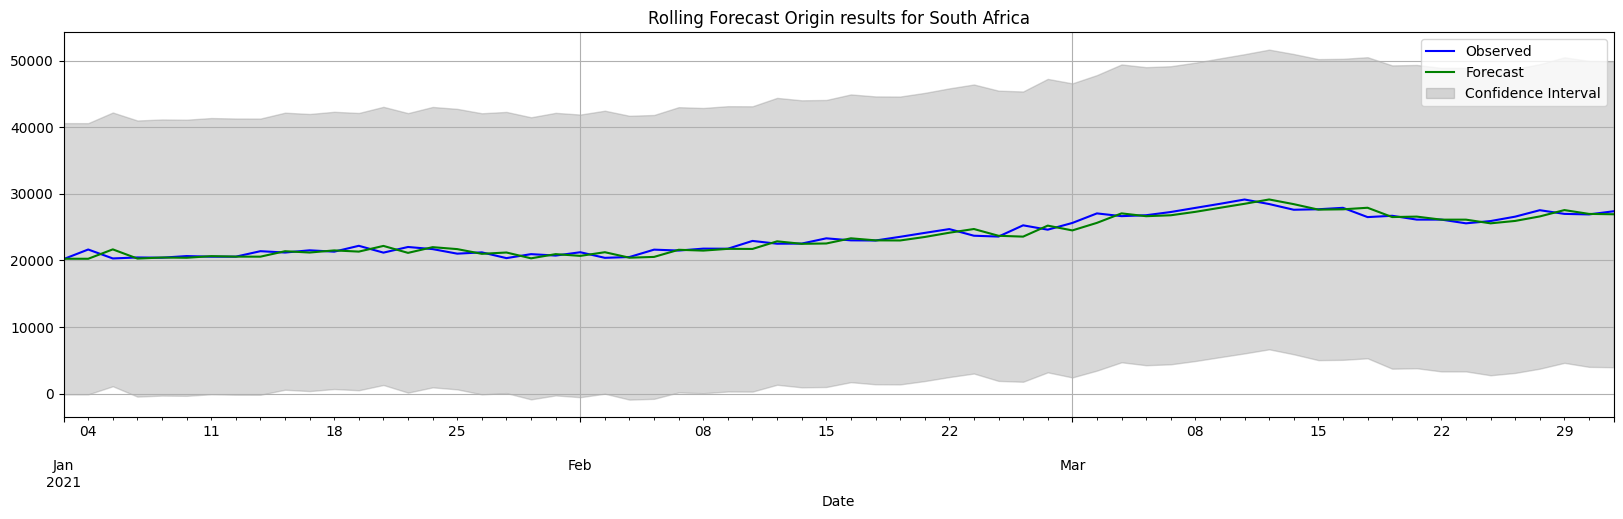

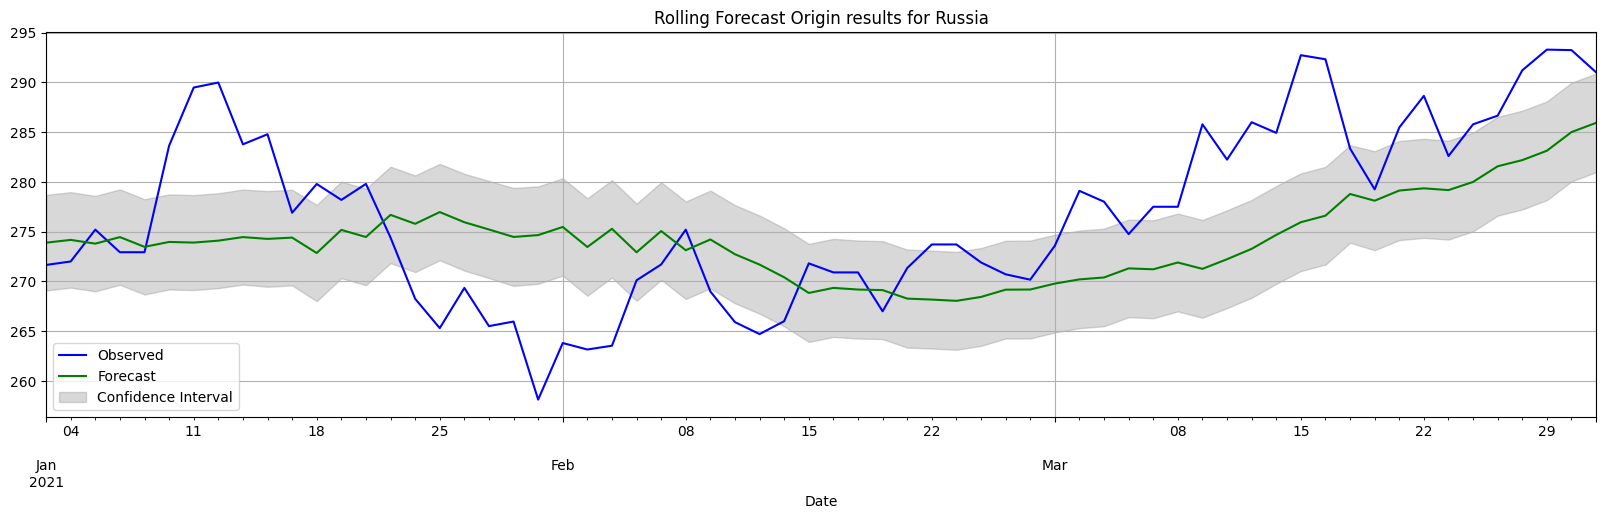

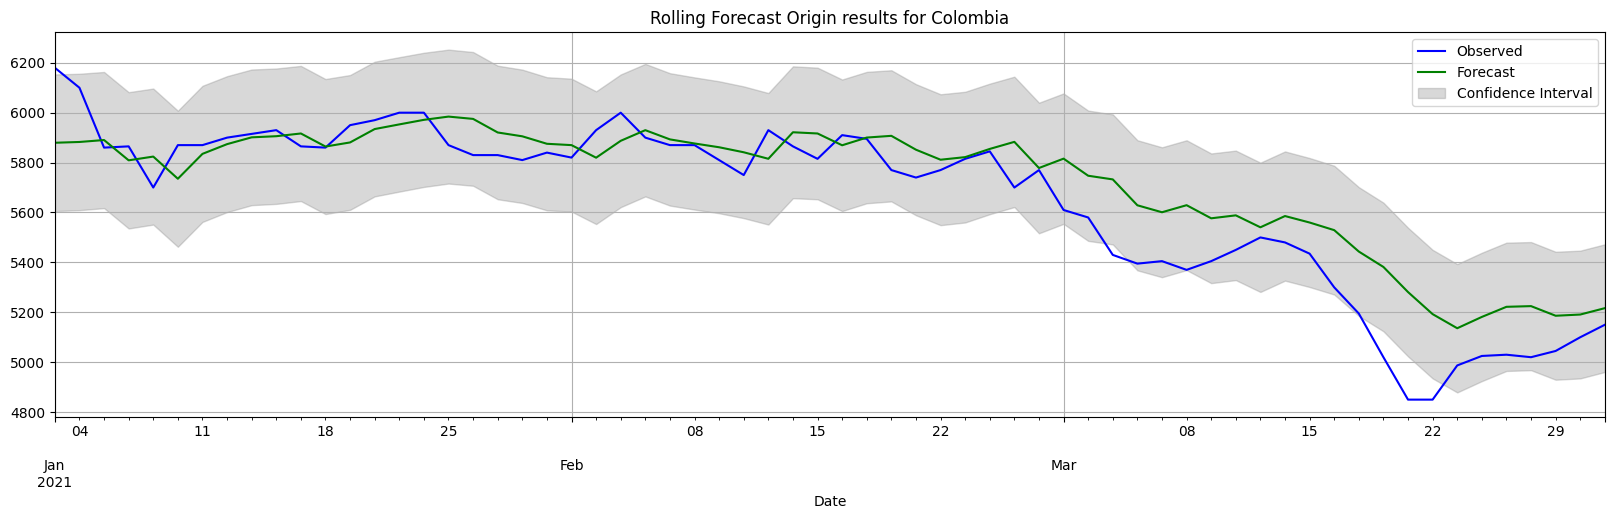

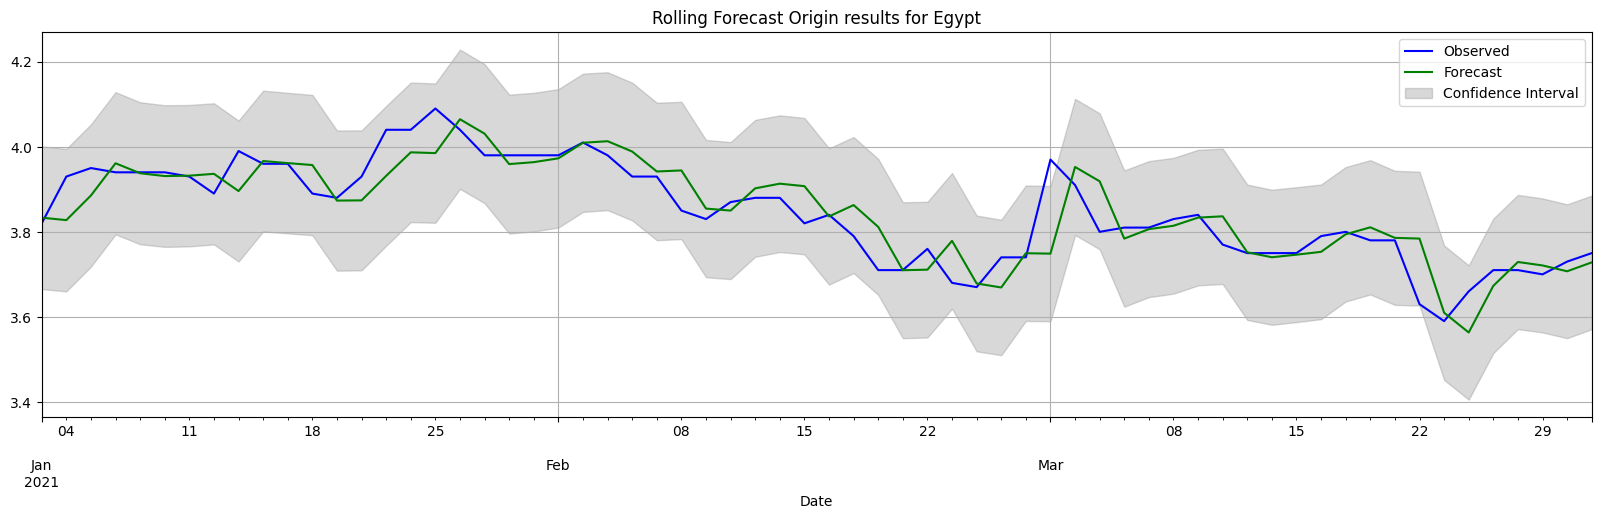

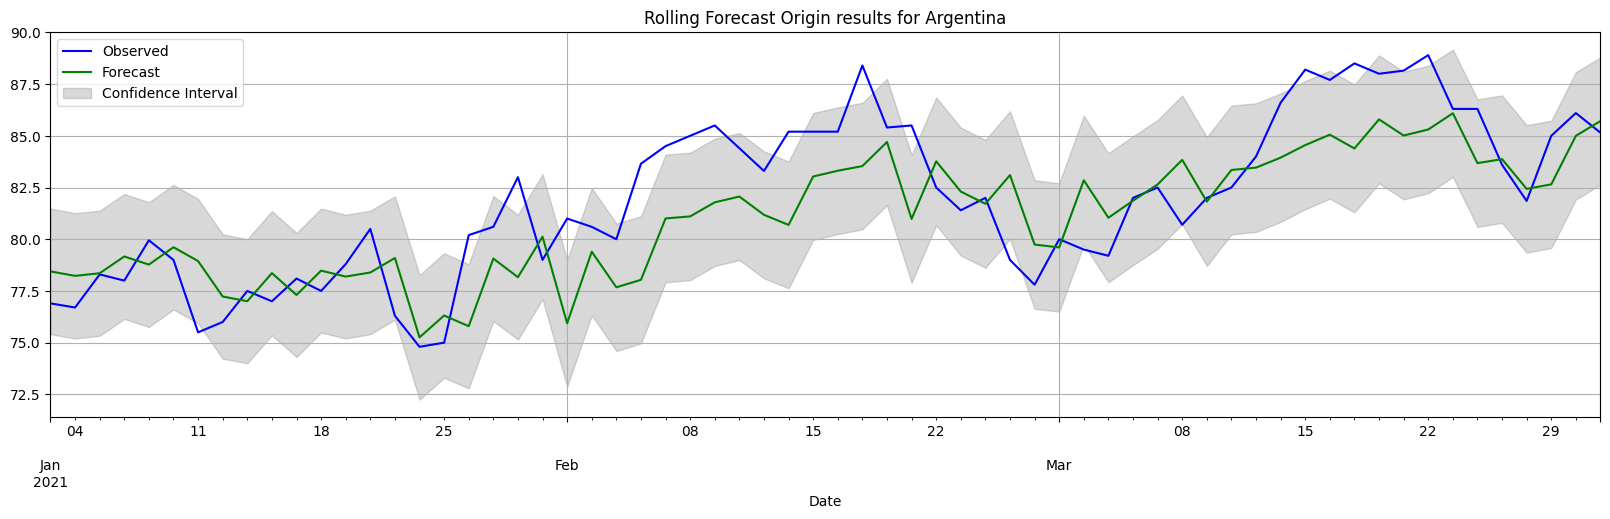

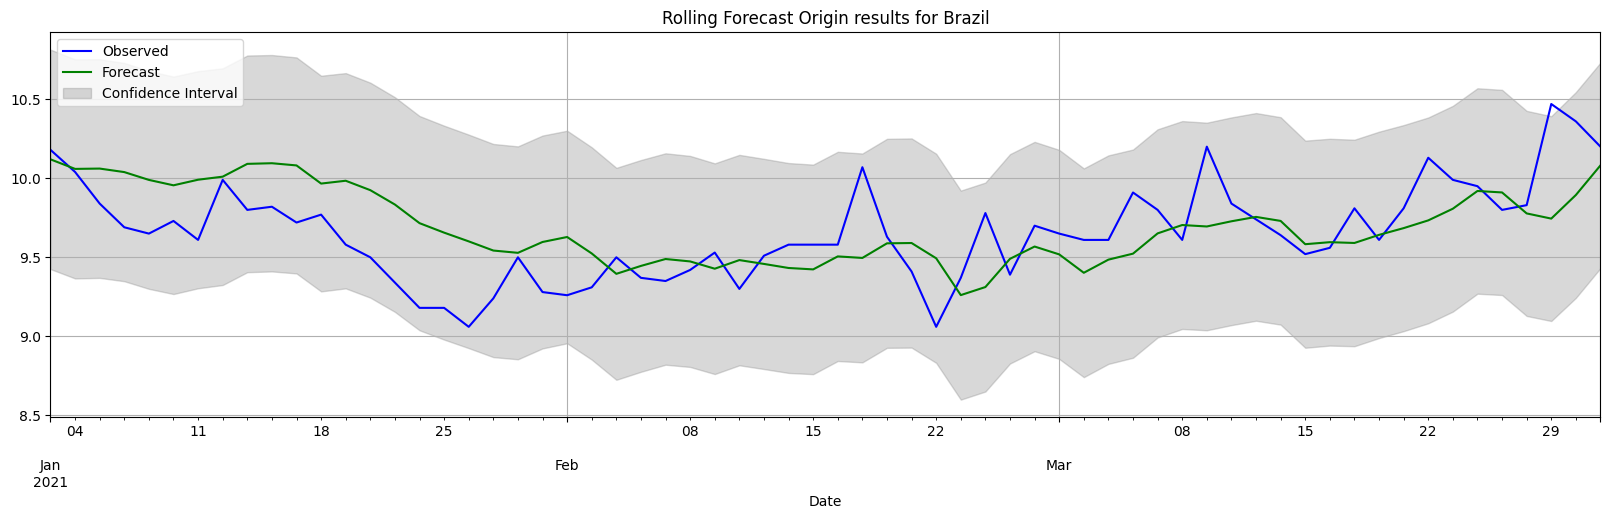

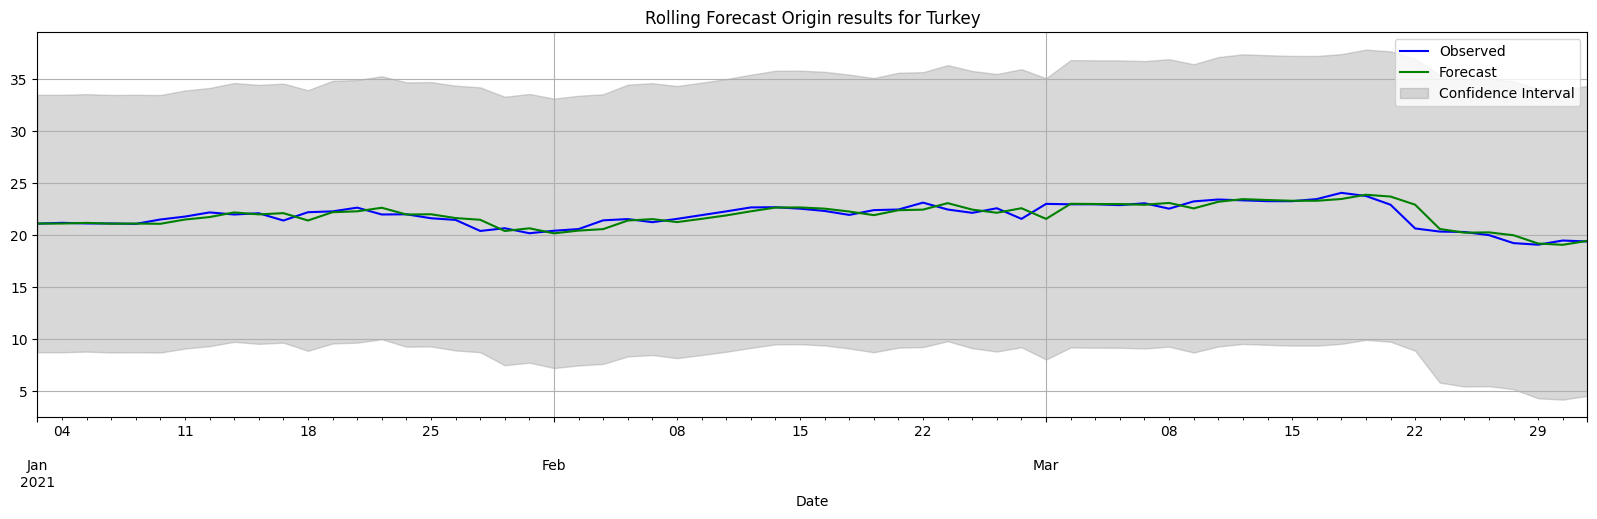

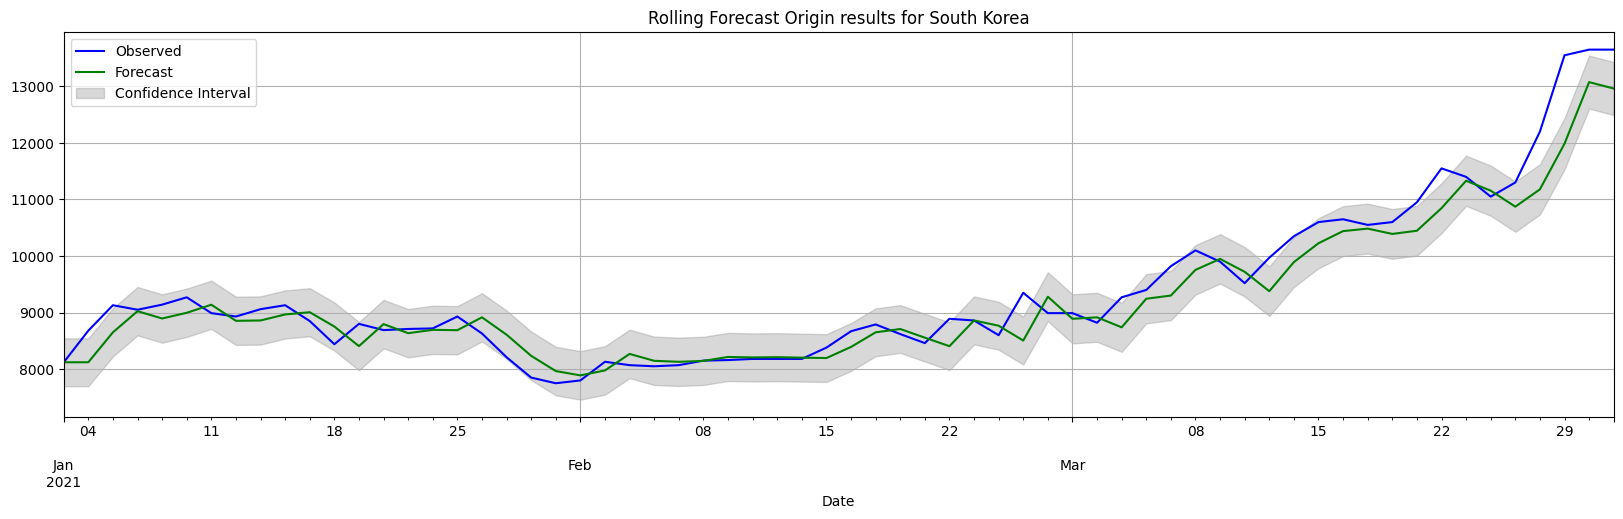

In [22]:
import warnings

# Filter out specific warning messages
warnings.filterwarnings("ignore")

plot = True
rfo_results = {}

for key in data.keys():

  # Initialize an empty DataFrame to store forecast results
  results = pd.DataFrame(columns=['Date', 'Actual', 'Forecast', 'Conf Int low', 'Conf Int high'])

  # Perform rolling forecasts
  for predicted_date in pd.date_range(start='2021-01-01', end='2021-03-31', freq='B'):

    # split the data according to the new prediciton date
    curr_train_set = data[key]['Price'][:predicted_date - timedelta(days=1)]
    curr_test_set = data[key]['Price'][predicted_date : predicted_date]

    # do the same thing for the exo variable
    if best_exo[key] == 'All':

      curr_train_exo = data[key][:predicted_date - timedelta(days=1)]
      curr_train_exo = curr_train_exo.drop('Price', axis=1)

    else:
      curr_train_exo = data[key][best_exo[key]][:predicted_date - timedelta(days=1)]

    # Build the test exo_var using the last moving average value
    exo_rolling_mean = curr_train_exo.rolling(window=window_size).mean()
    curr_test_exo = exo_rolling_mean[-1]

    # get the optimal order computed by auto ARIMA
    order = auto_models[key].order

    # create the model and fit it
    model = sm.tsa.SARIMAX(curr_train_set, order=order, exog=curr_train_exo)
    sarimax = model.fit()

    # make predictions
    forecast_results = sarimax.get_forecast(steps=1, exog=curr_test_exo)

    forecast = forecast_results.predicted_mean
    conf_int = forecast_results.conf_int()

    # Concat the results to the dataframe
    curr_results = pd.DataFrame({
        'Date': predicted_date,
        'Actual': curr_test_set,
        'Forecast': forecast,
        'Conf Int low': conf_int['lower Price'],
        'Conf Int high': conf_int['upper Price']
    })

    results = pd.concat((results, curr_results), ignore_index=True)

  # Once we have done the forecast of the full period, we save the results
  results.set_index('Date', inplace=True)
  rfo_results[key] = results

  # and we plot them if required
  if plot:
    results['Actual'].plot(label='Observed', color='blue', figsize=(20,5), grid='on')
    results['Forecast'].plot(label='Forecast', color='green', figsize=(20,5), grid='on')
    plt.fill_between(results.index, results['Conf Int low'], results['Conf Int high'], color='gray', alpha=0.3, label='Confidence Interval')
    plt.grid(True)
    plt.legend()
    plt.title(f'Rolling Forecast Origin results for {key}')
    plt.show()


warnings.resetwarnings()

In [23]:
with open('/content/gdrive/MyDrive/P5_files/rfo_auto_bestexo_ma_results.pkl', 'wb') as handle:
  pickle.dump(rfo_results, handle)

Compute the residuals and the error measures

In [25]:
for key in data.keys():
  tmp = rfo_results[key]

  residuals = tmp['Actual'] - tmp['Forecast']

  # Compute and store the performance metrics
  mape = round(np.mean(abs(residuals/tmp['Actual'])), 4)
  rmse = round(np.sqrt(np.mean(residuals**2)), 4)

  print(f'Rolling Forecast Origin performance metrics for {key}\n')
  print(f'Mean Absolute Percent Error: {round(mape * 100, 3)} %')
  print(f'Root Mean Square Error:  {round(rmse, 3)}')
  print('\n##########################################################\n')

Rolling Forecast Origin performance metrics for South Africa

Mean Absolute Percent Error: 2.26 %
Root Mean Square Error:  678.099

##########################################################

Rolling Forecast Origin performance metrics for Russia

Mean Absolute Percent Error: 2.4 %
Root Mean Square Error:  7.974

##########################################################

Rolling Forecast Origin performance metrics for Colombia

Mean Absolute Percent Error: 2.16 %
Root Mean Square Error:  152.221

##########################################################

Rolling Forecast Origin performance metrics for Egypt

Mean Absolute Percent Error: 1.08 %
Root Mean Square Error:  0.06

##########################################################

Rolling Forecast Origin performance metrics for Argentina

Mean Absolute Percent Error: 2.47 %
Root Mean Square Error:  2.528

##########################################################

Rolling Forecast Origin performance metrics for Brazil

Mean Absolut

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Investment strategy - Bolliger Bands

In [27]:
with open('/content/gdrive/MyDrive/P5_files/rfo_auto_bestexo_ma_results.pkl', 'rb') as handle:
  results = pickle.load(handle)

compute the Bolliger Bands

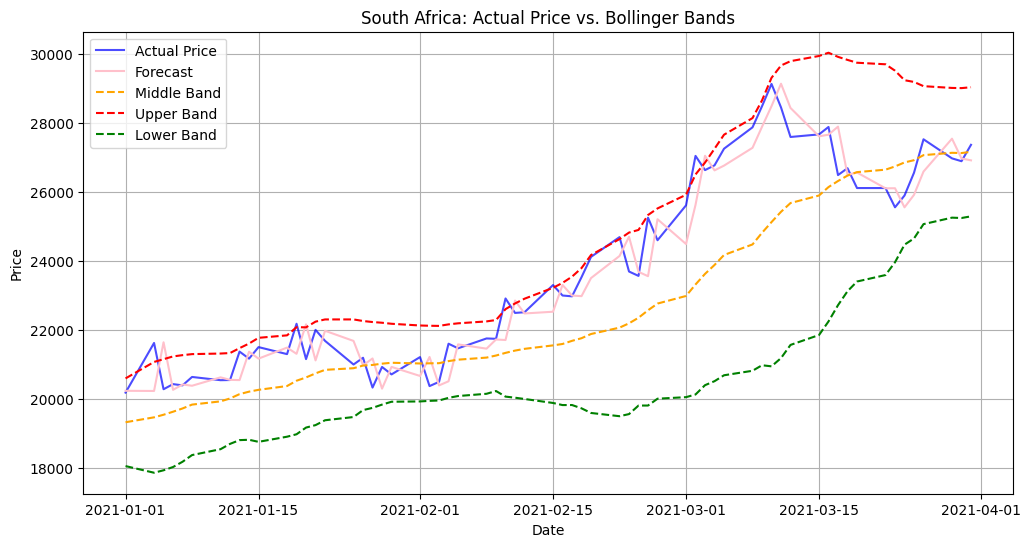

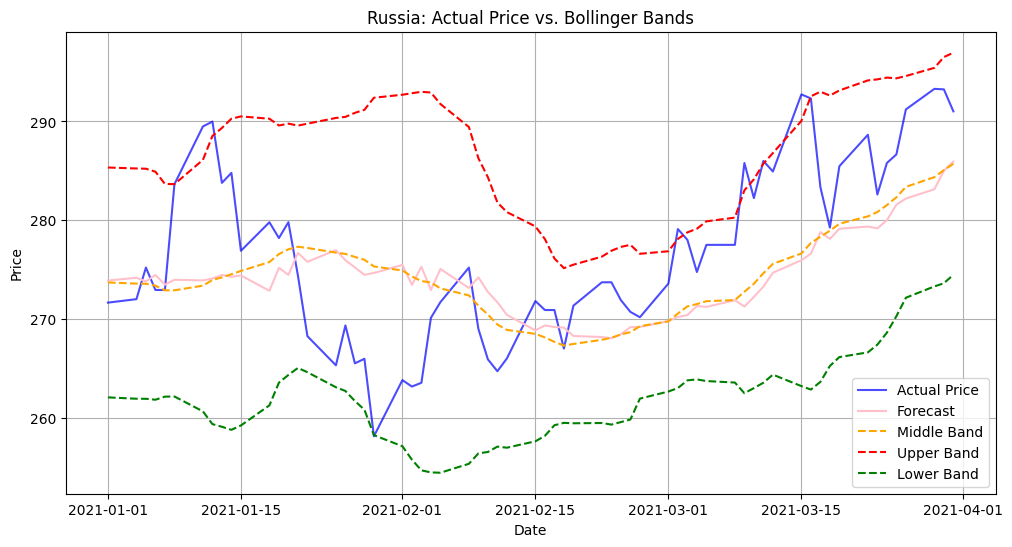

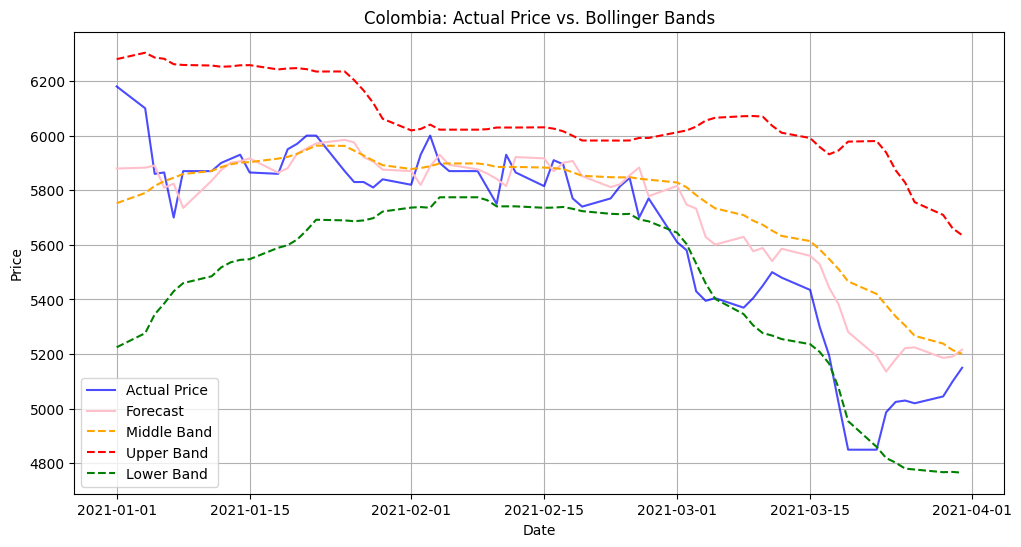

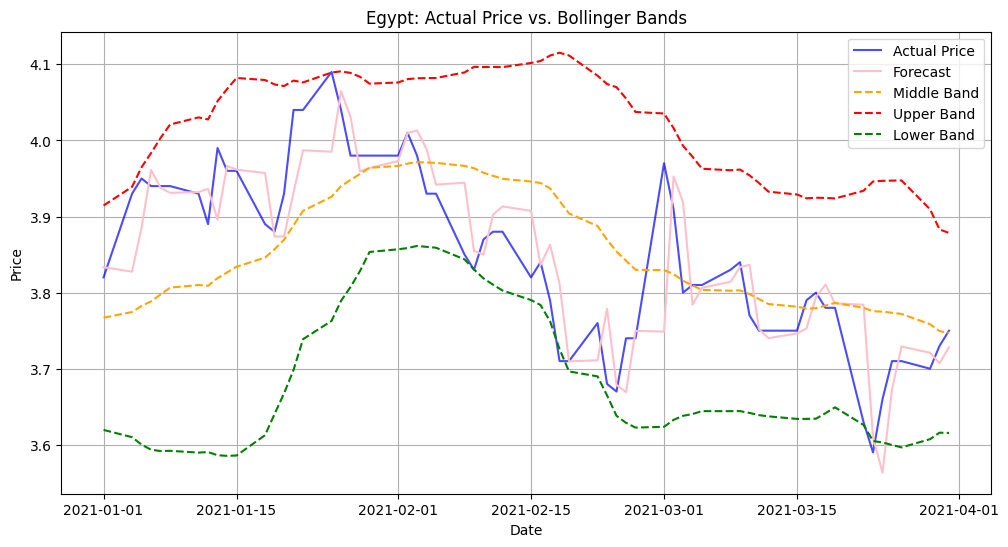

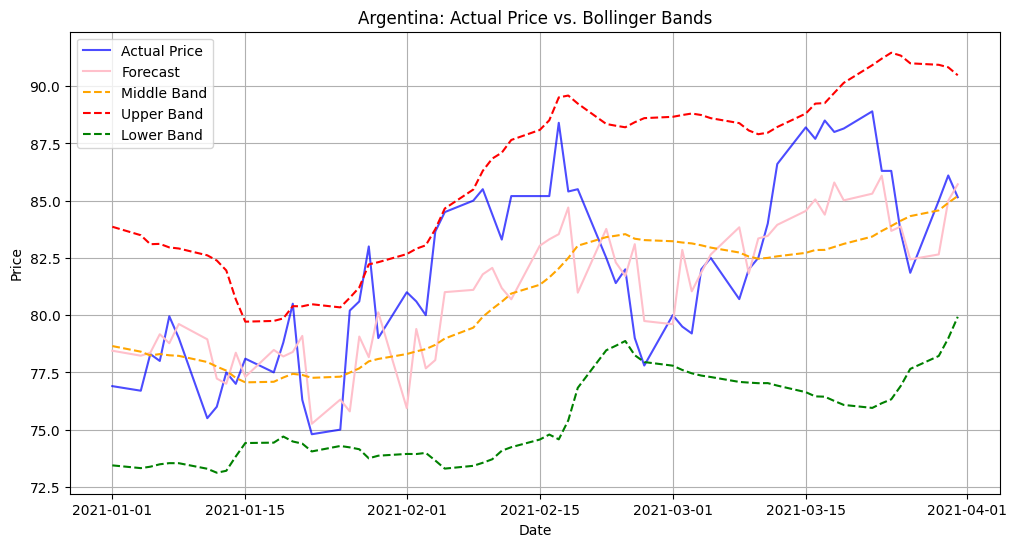

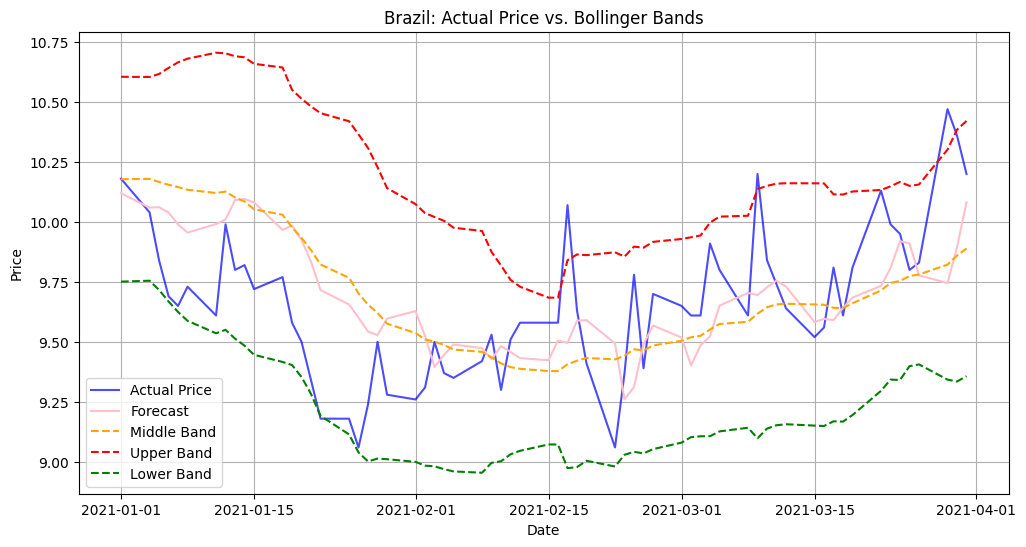

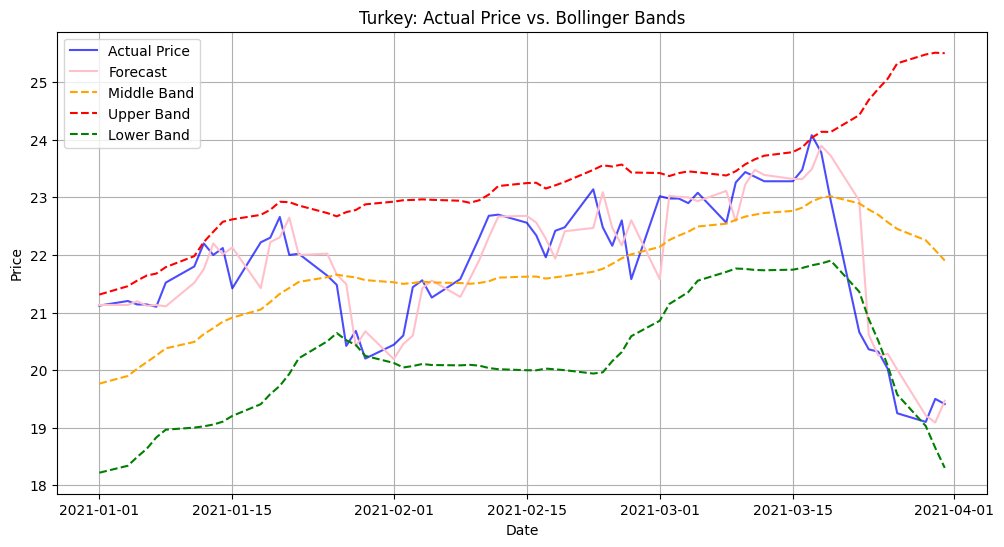

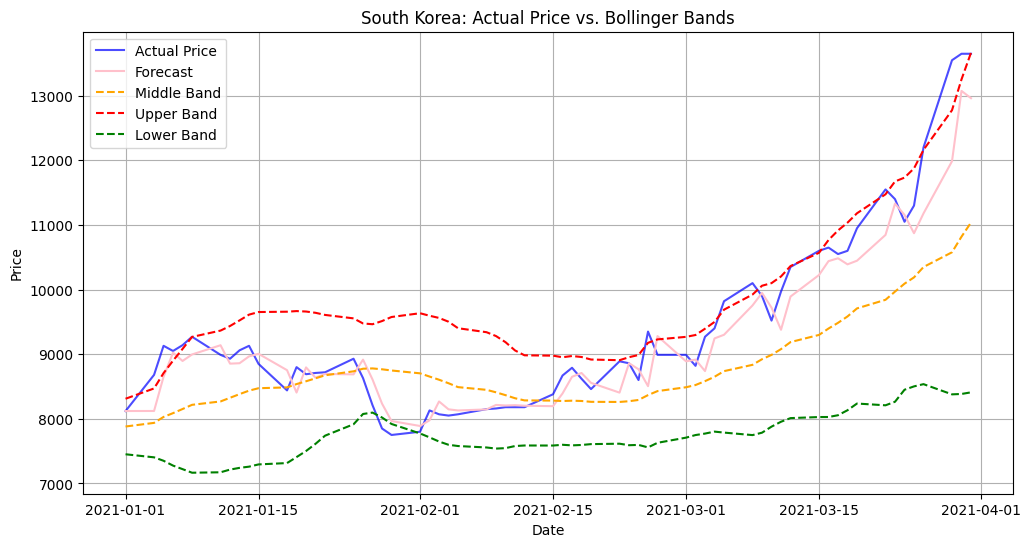

In [43]:
# Define the rolling window (typically 20 days) for the moving average and standard deviation.
window = 20
plot = True

for key in data.keys():

  rslt = results[key]

  start_test = datetime(2021,1,1)
  end_test = datetime(2021,3,31)

  # Calculate the rolling mean (Middle Band) and rolling standard deviation.
  tmp = data[key]['Price'].rolling(window=window).mean()
  rslt['mid_band'] = tmp.loc[start_test : end_test]

  tmp = data[key]['Price'].rolling(window=window).std()
  rslt['std_dev'] = tmp.loc[start_test : end_test]

  # Calculate the Upper and Lower Bollinger Bands.
  rslt['upper_band'] = rslt['mid_band'] + 2 * rslt['std_dev']
  rslt['lower_band'] = rslt['mid_band'] - 2 * rslt['std_dev']

  if plot:

    date = rslt['mid_band'].index

    # Create a plot.
    plt.figure(figsize=(12, 6))
    plt.plot(date, results[key]['Actual'], label='Actual Price', color='blue', alpha=0.7)
    plt.plot(date, results[key]['Forecast'], label='Forecast', color='pink')
    plt.plot(date, rslt['mid_band'], label='Middle Band', color='orange', linestyle='--')
    plt.plot(date, rslt['upper_band'], label='Upper Band', color='red', linestyle='--')
    plt.plot(date, rslt['lower_band'], label='Lower Band', color='green', linestyle='--')

    # Add labels and a legend.
    plt.title(f'{key}: Actual Price vs. Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    # Show the plot.
    plt.grid(True)
    plt.show()

  results[key] = rslt

In [41]:
with open('/content/gdrive/MyDrive/P5_files/rfo_auto_bestexo_ma_results_BB.pkl', 'wb') as handle:
  pickle.dump(results, handle)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Generate the trading signals